<a href="https://colab.research.google.com/github/JohnSmith69969/ADS2002-Monash-Solar-Group/blob/main/Solar_Rand_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [360]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import date, time
from matplotlib import pyplot as plt
import seaborn as sns
import random
from logitplots import plt_confusion_matrix, plt_decision_boundaries, plt_correlation_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score # for comparing the predicted and test values
from sklearn.model_selection import train_test_split # for splitting the data into training and testing sets
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
import statsmodels.api as sm
import math as m
from sklearn.linear_model import LinearRegression
plt.style.use('seaborn')

<ipython-input-360-54b39a552094>:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [361]:
from datetime import datetime
from distutils.util import strtobool

import pandas as pd



# Converts the contents in a .tsf file into a dataframe and returns it along with other meta-data of the dataset: frequency, horizon, whether the dataset contains missing values and whether the series have equal lengths
#
# Parameters
# full_file_path_and_name - complete .tsf file path
# replace_missing_vals_with - a term to indicate the missing values in series in the returning dataframe
# value_column_name - Any name that is preferred to have as the name of the column containing series values in the re
def convert_tsf_to_dataframe(
    full_file_path_and_name,
    replace_missing_vals_with="NaN",
    value_column_name="series_value",
):
    col_names = []
    col_types = []
    all_data = {}
    line_count = 0
    frequency = None
    forecast_horizon = None
    contain_missing_values = None
    contain_equal_length = None
    found_data_tag = False
    found_data_section = False
    started_reading_data_section = False

    with open(full_file_path_and_name, "r", encoding="cp1252") as file:
        for line in file:
            # Strip white space from start/end of line
            line = line.strip()

            if line:
                if line.startswith("@"):  # Read meta-data
                    if not line.startswith("@data"):
                        line_content = line.split(" ")
                        if line.startswith("@attribute"):
                            if (
                                len(line_content) != 3
                            ):  # Attributes have both name and type
                                raise Exception("Invalid meta-data specification.")

                            col_names.append(line_content[1])
                            col_types.append(line_content[2])
                        else:
                            if (
                                len(line_content) != 2
                            ):  # Other meta-data have only values
                                raise Exception("Invalid meta-data specification.")

                            if line.startswith("@frequency"):
                                frequency = line_content[1]
                            elif line.startswith("@horizon"):
                                forecast_horizon = int(line_content[1])
                            elif line.startswith("@missing"):
                                contain_missing_values = bool(
                                    strtobool(line_content[1])
                                )
                            elif line.startswith("@equallength"):
                                contain_equal_length = bool(strtobool(line_content[1]))

                    else:
                        if len(col_names) == 0:
                            raise Exception(
                                "Missing attribute section. Attribute section must come before data."
                            )

                        found_data_tag = True
                elif not line.startswith("#"):
                    if len(col_names) == 0:
                        raise Exception(
                            "Missing attribute section. Attribute section must come before data."
                        )
                    elif not found_data_tag:
                        raise Exception("Missing @data tag.")
                    else:
                        if not started_reading_data_section:
                            started_reading_data_section = True
                            found_data_section = True
                            all_series = []

                            for col in col_names:
                                all_data[col] = []

                        full_info = line.split(":")

                        if len(full_info) != (len(col_names) + 1):
                            raise Exception("Missing attributes/values in series.")

                        series = full_info[len(full_info) - 1]
                        series = series.split(",")

                        if len(series) == 0:
                            raise Exception(
                                "A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series. Missing values should be indicated with ? symbol"
                            )

                        numeric_series = []

                        for val in series:
                            if val == "?":
                                numeric_series.append(replace_missing_vals_with)
                            else:
                                numeric_series.append(float(val))

                        if numeric_series.count(replace_missing_vals_with) == len(
                            numeric_series
                        ):
                            raise Exception(
                                "All series values are missing. A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series."
                            )

                        all_series.append(pd.Series(numeric_series).array)

                        for i in range(len(col_names)):
                            att_val = None
                            if col_types[i] == "numeric":
                                att_val = int(full_info[i])
                            elif col_types[i] == "string":
                                att_val = str(full_info[i])
                            elif col_types[i] == "date":
                                att_val = datetime.strptime(
                                    full_info[i], "%Y-%m-%d %H-%M-%S"
                                )
                            else:
                                raise Exception(
                                    "Invalid attribute type."
                                )  # Currently, the code supports only numeric, string and date types. Extend this as required.

                            if att_val is None:
                                raise Exception("Invalid attribute value.")
                            else:
                                all_data[col_names[i]].append(att_val)

                line_count = line_count + 1

        if line_count == 0:
            raise Exception("Empty file.")
        if len(col_names) == 0:
            raise Exception("Missing attribute section.")
        if not found_data_section:
            raise Exception("Missing series information under data section.")

        all_data[value_column_name] = all_series
        loaded_data = pd.DataFrame(all_data)

        return (
            loaded_data,
            frequency,
            forecast_horizon,
            contain_missing_values,
            contain_equal_length,
        )


#loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = convert_tsf_to_dataframe("TSForecasting/tsf_data/sample.tsf")

#print(loaded_data)
#print(frequency)
#print(forecast_horizon)
#print(contain_missing_values)
#print(contain_equal_length)

# Loading data

In [362]:
test = pd.read_csv("NOV_test_data.csv")
test

,Unnamed: 0,Date,Building0,Building1,Building3,Building4,Building5,Building6,Solar0,Solar1,Solar2,Solar3,Solar4,Solar5
0,0,2020-11-01 10:00:00,77.6,10.1,327.0,1.0,NaN,27.6,31.90,7.95,8.26,7.69,5.13,23.01
1,1,2020-11-01 10:15:00,25.7,3.1,315.0,NaN,NaN,27.6,32.02,8.51,8.11,7.52,5.01,23.73
2,2,2020-11-01 10:30:00,25.7,5.3,315.0,NaN,NaN,25.6,32.14,9.07,7.95,7.35,4.89,24.45
3,3,2020-11-01 10:45:00,25.7,7.9,315.0,1.0,NaN,25.6,36.68,9.38,9.12,8.15,5.59,28.05
4,4,2020-11-01 11:00:00,25.7,10.5,315.0,NaN,NaN,28.6,41.22,9.68,10.29,8.96,6.29,31.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,2875,2020-12-01 08:45:00,218.6,17.3,554.0,1.0,18.0,40.0,13.21,2.32,2.21,3.11,1.31,9.86
2876,2876,2020-12-01 09:00:00,218.6,23.1,554.0,1.0,36.0,46.4,8.24,2.21,2.10,1.97,1.25,6.22
2877,2877,2020-12-01 09:15:00,207.2,6.6,694.0,2.0,18.0,46.4,9.42,2.00,1.90,2.24,1.13,7.14
2878,2878,2020-12-01 09:30:00,207.2,11.0,694.0,1.0,18.0,44.6,7.63,1.78,1.70,1.78,1.01,5.64


In [363]:
train = convert_tsf_to_dataframe("nov_data.tsf")
train

(   series_name     start_timestamp  \
 0    Building0 2016-07-03 21:30:00   
 1    Building1 2019-01-09 23:15:00   
 2    Building3 2016-03-01 04:15:00   
 3    Building4 2019-07-03 04:45:00   
 4    Building5 2019-07-25 23:00:00   
 5    Building6 2019-07-25 01:45:00   
 6       Solar0 2020-04-25 14:00:00   
 7       Solar1 2018-12-31 13:00:00   
 8       Solar2 2019-06-05 14:00:00   
 9       Solar3 2019-06-05 14:00:00   
 10      Solar4 2019-06-05 14:00:00   
 11      Solar5 2019-01-15 13:00:00   
 
                                          series_value  
 0   [283.8, 283.8, 283.8, 606.0, 606.0, 606.0, 606...  
 1   [8.1, 15.7, 22.8, 32.7, 8.1, 16.5, 24.7, 34.5,...  
 2   [1321.0, 1321.0, 1321.0, 1321.0, 1293.0, 1293....  
 3   [2.0, NaN, 1.0, 2.0, NaN, 2.0, NaN, NaN, 2.0, ...  
 4   [30.0, 31.0, 24.0, 34.0, 30.0, 31.0, 26.0, 33....  
 5   [36.8, 34.6, 34.6, 36.2, 36.2, 35.2, 35.2, 35....  
 6   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
 7   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

# Data cleaning

In [364]:

testing = pd.read_csv('NOV_test_data.csv')
testing = testing.drop(['Building0','Building1','Building3','Building4','Building5','Building6'], axis=1)
testing = testing.dropna(axis=0)
testing = testing.set_index(pd.DatetimeIndex(testing['Date'])).drop(['Date'], axis=1)
testing

,Unnamed: 0,Solar0,Solar1,Solar2,Solar3,Solar4,Solar5
Date,,,,,,,
2020-11-01 10:00:00,0,31.90,7.95,8.26,7.69,5.13,23.01
2020-11-01 10:15:00,1,32.02,8.51,8.11,7.52,5.01,23.73
2020-11-01 10:30:00,2,32.14,9.07,7.95,7.35,4.89,24.45
2020-11-01 10:45:00,3,36.68,9.38,9.12,8.15,5.59,28.05
2020-11-01 11:00:00,4,41.22,9.68,10.29,8.96,6.29,31.63
...,...,...,...,...,...,...,...
2020-12-01 08:45:00,2875,13.21,2.32,2.21,3.11,1.31,9.86
2020-12-01 09:00:00,2876,8.24,2.21,2.10,1.97,1.25,6.22
2020-12-01 09:15:00,2877,9.42,2.00,1.90,2.24,1.13,7.14


In [365]:

Phase_2 = convert_tsf_to_dataframe("phase_2_data.tsf")
Phase_2

(   series_name     start_timestamp  \
 0    Building0 2016-07-03 21:30:00   
 1    Building1 2019-01-09 23:15:00   
 2    Building3 2016-03-01 04:15:00   
 3    Building4 2019-07-03 04:45:00   
 4    Building5 2019-07-25 23:00:00   
 5    Building6 2019-07-25 01:45:00   
 6       Solar0 2020-04-25 14:00:00   
 7       Solar1 2018-12-31 13:00:00   
 8       Solar2 2019-06-05 14:00:00   
 9       Solar3 2019-06-05 14:00:00   
 10      Solar4 2019-06-05 14:00:00   
 11      Solar5 2019-01-15 13:00:00   
 
                                          series_value  
 0   [283.8, 283.8, 283.8, 606.0, 606.0, 606.0, 606...  
 1   [8.1, 15.7, 22.8, 32.7, 8.1, 16.5, 24.7, 34.5,...  
 2   [1321.0, 1321.0, 1321.0, 1321.0, 1293.0, 1293....  
 3   [2.0, NaN, 1.0, 2.0, NaN, 2.0, NaN, NaN, 2.0, ...  
 4   [30.0, 31.0, 24.0, 34.0, 30.0, 31.0, 26.0, 33....  
 5   [36.8, 34.6, 34.6, 36.2, 36.2, 35.2, 35.2, 35....  
 6   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
 7   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [366]:

loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = Phase_2

In [367]:
dataset = loaded_data.explode('series_value')
dataset

,series_name,start_timestamp,series_value
0,Building0,2016-07-03 21:30:00,283.8
0,Building0,2016-07-03 21:30:00,283.8
0,Building0,2016-07-03 21:30:00,283.8
0,Building0,2016-07-03 21:30:00,606.0
0,Building0,2016-07-03 21:30:00,606.0
...,...,...,...
11,Solar5,2019-01-15 13:00:00,13.47
11,Solar5,2019-01-15 13:00:00,15.93
11,Solar5,2019-01-15 13:00:00,17.11
11,Solar5,2019-01-15 13:00:00,18.29


In [368]:

solar_0 = dataset.loc[dataset['series_name']=='Solar0']
solar_0

,series_name,start_timestamp,series_value
6,Solar0,2020-04-25 14:00:00,0.0
6,Solar0,2020-04-25 14:00:00,0.0
6,Solar0,2020-04-25 14:00:00,0.0
6,Solar0,2020-04-25 14:00:00,0.0
6,Solar0,2020-04-25 14:00:00,0.0
...,...,...,...
6,Solar0,2020-04-25 14:00:00,18.53
6,Solar0,2020-04-25 14:00:00,22.23
6,Solar0,2020-04-25 14:00:00,23.39
6,Solar0,2020-04-25 14:00:00,24.56


In [369]:
import datetime

# Input start date
start_date_str = '25/04/2020 14:00:00'
start_date = datetime.datetime.strptime(start_date_str, '%d/%m/%Y %H:%M:%S')

# Interval duration
interval_duration = datetime.timedelta(minutes=15)

# Number of intervals
num_intervals = len(loaded_data['series_value'][6])

# Calculate the end date
end_date = start_date + interval_duration * (num_intervals-1)

# Print the end date
print("End Date:", end_date.strftime('%d/%m/%Y %H:%M:%S'))

End Date: 31/10/2020 23:45:00


In [370]:

end_date_str = '31/10/2020 23:45:00'

# Convert start and end date strings to datetime objects
end_date = pd.to_datetime(end_date_str)

# Create a column of datetime values between start and end date with a frequency of 15 minutes
datetime_column = pd.date_range(start=start_date, end=end_date, freq='15T')

#building_0['start_timestamp']=datetime_column
solar_0['start_timestamp']=datetime_column

<ipython-input-370-362cacee587e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_0['start_timestamp']=datetime_column


In [371]:
solar_0 = solar_0.rename(columns={"series_name": "solar_no", "start_timestamp": "timestamp","series_value":"power_output"})
solar_0 = solar_0[solar_0.power_output != "NaN"]
solar_0["power_output"] = pd.to_numeric(solar_0["power_output"])
solar_0

,solar_no,timestamp,power_output
6,Solar0,2020-04-25 14:00:00,0.00
6,Solar0,2020-04-25 14:15:00,0.00
6,Solar0,2020-04-25 14:30:00,0.00
6,Solar0,2020-04-25 14:45:00,0.00
6,Solar0,2020-04-25 15:00:00,0.00
...,...,...,...
6,Solar0,2020-10-31 22:45:00,18.53
6,Solar0,2020-10-31 23:00:00,22.23
6,Solar0,2020-10-31 23:15:00,23.39
6,Solar0,2020-10-31 23:30:00,24.56


In [372]:

solar_1 = dataset.loc[dataset['series_name']=='Solar1']
solar_1

,series_name,start_timestamp,series_value
7,Solar1,2018-12-31 13:00:00,0.0
7,Solar1,2018-12-31 13:00:00,0.0
7,Solar1,2018-12-31 13:00:00,0.0
7,Solar1,2018-12-31 13:00:00,0.0
7,Solar1,2018-12-31 13:00:00,0.0
...,...,...,...
7,Solar1,2018-12-31 13:00:00,4.96
7,Solar1,2018-12-31 13:00:00,5.88
7,Solar1,2018-12-31 13:00:00,6.31
7,Solar1,2018-12-31 13:00:00,6.73


In [373]:
import datetime

# Input start date
start_date_str = '31/12/2018 13:00:00'
start_date = datetime.datetime.strptime(start_date_str, '%d/%m/%Y %H:%M:%S')

# Interval duration
interval_duration = datetime.timedelta(minutes=15)

# Number of intervals
num_intervals = len(loaded_data['series_value'][7])

# Calculate the end date
end_date = start_date + interval_duration * (num_intervals-1)

# Print the end date
print("End Date:", end_date.strftime('%d/%m/%Y %H:%M:%S'))

End Date: 31/10/2020 23:45:00


In [374]:
end_date_str = '31/10/2020 23:45:00'

# Convert start and end date strings to datetime objects
end_date = pd.to_datetime(end_date_str)

# Create a column of datetime values between start and end date with a frequency of 15 minutes
datetime_column = pd.date_range(start=start_date, end=end_date, freq='15T')

#building_0['start_timestamp']=datetime_column
solar_1['start_timestamp']=datetime_column

<ipython-input-374-6ca112a44dc9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_1['start_timestamp']=datetime_column


In [375]:
solar_1 = solar_1.rename(columns={"series_name": "solar_no", "start_timestamp": "timestamp","series_value":"power_output"})
solar_1 = solar_1[solar_1.power_output != "NaN"]
solar_1["power_output"] = pd.to_numeric(solar_1["power_output"])
solar_1

,solar_no,timestamp,power_output
7,Solar1,2018-12-31 13:00:00,0.00
7,Solar1,2018-12-31 13:15:00,0.00
7,Solar1,2018-12-31 13:30:00,0.00
7,Solar1,2018-12-31 13:45:00,0.00
7,Solar1,2018-12-31 14:00:00,0.00
...,...,...,...
7,Solar1,2020-10-31 22:45:00,4.96
7,Solar1,2020-10-31 23:00:00,5.88
7,Solar1,2020-10-31 23:15:00,6.31
7,Solar1,2020-10-31 23:30:00,6.73


In [376]:

solar_2 = dataset.loc[dataset['series_name']=='Solar2']
solar_2

,series_name,start_timestamp,series_value
8,Solar2,2019-06-05 14:00:00,0.0
8,Solar2,2019-06-05 14:00:00,0.0
8,Solar2,2019-06-05 14:00:00,0.0
8,Solar2,2019-06-05 14:00:00,0.0
8,Solar2,2019-06-05 14:00:00,0.0
...,...,...,...
8,Solar2,2019-06-05 14:00:00,4.73
8,Solar2,2019-06-05 14:00:00,5.64
8,Solar2,2019-06-05 14:00:00,5.99
8,Solar2,2019-06-05 14:00:00,6.35


In [377]:
import datetime

# Input start date
start_date_str = '05/06/2019 14:00:00'
start_date = datetime.datetime.strptime(start_date_str, '%d/%m/%Y %H:%M:%S')

# Interval duration
interval_duration = datetime.timedelta(minutes=15)

# Number of intervals
num_intervals = len(loaded_data['series_value'][8])

# Calculate the end date
end_date = start_date + interval_duration * (num_intervals-1)

# Print the end date
print("End Date:", end_date.strftime('%d/%m/%Y %H:%M:%S'))

End Date: 31/10/2020 23:45:00


In [378]:
end_date_str = '31/10/2020 23:45:00'

# Convert start and end date strings to datetime objects
end_date = pd.to_datetime(end_date_str)

# Create a column of datetime values between start and end date with a frequency of 15 minutes
datetime_column = pd.date_range(start=start_date, end=end_date, freq='15T')

#building_0['start_timestamp']=datetime_column
solar_2['start_timestamp']=datetime_column

<ipython-input-378-725571f5cdf1>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_2['start_timestamp']=datetime_column


In [379]:
solar_2 = solar_2.rename(columns={"series_name": "solar_no", "start_timestamp": "timestamp","series_value":"power_output"})
solar_2 = solar_2[solar_2.power_output != "NaN"]
solar_2["power_output"] = pd.to_numeric(solar_2["power_output"])
solar_2

,solar_no,timestamp,power_output
8,Solar2,2019-06-05 14:00:00,0.00
8,Solar2,2019-06-05 14:15:00,0.00
8,Solar2,2019-06-05 14:30:00,0.00
8,Solar2,2019-06-05 14:45:00,0.00
8,Solar2,2019-06-05 15:00:00,0.00
...,...,...,...
8,Solar2,2020-10-31 22:45:00,4.73
8,Solar2,2020-10-31 23:00:00,5.64
8,Solar2,2020-10-31 23:15:00,5.99
8,Solar2,2020-10-31 23:30:00,6.35


In [380]:
solar0_test = testing[['Solar0']]
solar0_test = solar0_test.rename({'Solar0': 'Power output'}, axis=1)
solar0_test = solar0_test.dropna(axis =0)
solar0_test = solar0_test[pd.Timestamp('2020-11-01 00:00:00'):pd.Timestamp("2020-12-01 00:00:00")]
solar0_test

,Power output
Date,
2020-11-01 10:00:00,31.90
2020-11-01 10:15:00,32.02
2020-11-01 10:30:00,32.14
2020-11-01 10:45:00,36.68
2020-11-01 11:00:00,41.22
...,...
2020-11-30 23:00:00,0.01
2020-11-30 23:15:00,0.01
2020-11-30 23:30:00,0.01


In [381]:
solar1_test = testing[['Solar1']]
solar1_test = solar1_test.rename({'Solar1': 'Power output'}, axis=1)
solar1_test = solar1_test.dropna(axis =0)
solar1_test = solar1_test[pd.Timestamp('2020-11-01 00:00:00'):pd.Timestamp("2020-12-01 00:00:00")]
solar1_test

,Power output
Date,
2020-11-01 10:00:00,7.95
2020-11-01 10:15:00,8.51
2020-11-01 10:30:00,9.07
2020-11-01 10:45:00,9.38
2020-11-01 11:00:00,9.68
...,...
2020-11-30 23:00:00,0.00
2020-11-30 23:15:00,0.00
2020-11-30 23:30:00,0.00


In [382]:
solar2_test = testing[['Solar2']]
solar2_test = solar2_test.rename({'Solar2': 'Power output'}, axis=1)
solar2_test = solar2_test.dropna(axis =0)
solar2_test = solar2_test[pd.Timestamp('2020-11-01 00:00:00'):pd.Timestamp("2020-12-01 00:00:00")]
solar2_test

,Power output
Date,
2020-11-01 10:00:00,8.26
2020-11-01 10:15:00,8.11
2020-11-01 10:30:00,7.95
2020-11-01 10:45:00,9.12
2020-11-01 11:00:00,10.29
...,...
2020-11-30 23:00:00,0.00
2020-11-30 23:15:00,0.00
2020-11-30 23:30:00,0.00


In [383]:
solar3_test = testing[['Solar3']]
solar3_test = solar3_test.rename({'Solar3': 'Power output'}, axis=1)
solar3_test = solar3_test.dropna(axis =0)
solar3_test = solar3_test[pd.Timestamp('2020-11-01 00:00:00'):pd.Timestamp("2020-12-01 00:00:00")]
solar3_test

,Power output
Date,
2020-11-01 10:00:00,7.69
2020-11-01 10:15:00,7.52
2020-11-01 10:30:00,7.35
2020-11-01 10:45:00,8.15
2020-11-01 11:00:00,8.96
...,...
2020-11-30 23:00:00,0.00
2020-11-30 23:15:00,0.00
2020-11-30 23:30:00,0.00


In [384]:
solar4_test = testing[['Solar4']]
solar4_test = solar4_test.rename({'Solar4': 'Power output'}, axis=1)
solar4_test = solar4_test.dropna(axis =0)
solar4_test = solar4_test[pd.Timestamp('2020-11-01 00:00:00'):pd.Timestamp("2020-12-01 00:00:00")]
solar4_test

,Power output
Date,
2020-11-01 10:00:00,5.13
2020-11-01 10:15:00,5.01
2020-11-01 10:30:00,4.89
2020-11-01 10:45:00,5.59
2020-11-01 11:00:00,6.29
...,...
2020-11-30 23:00:00,0.00
2020-11-30 23:15:00,0.00
2020-11-30 23:30:00,0.00


In [385]:
solar5_test = testing[['Solar5']]
solar5_test = solar5_test.rename({'Solar5': 'Power output'}, axis=1)
solar5_test = solar5_test.dropna(axis =0)
solar5_test = solar5_test[pd.Timestamp('2020-11-01 00:00:00'):pd.Timestamp("2020-12-01 00:00:00")]
solar5_test

,Power output
Date,
2020-11-01 10:00:00,23.01
2020-11-01 10:15:00,23.73
2020-11-01 10:30:00,24.45
2020-11-01 10:45:00,28.05
2020-11-01 11:00:00,31.63
...,...
2020-11-30 23:00:00,0.00
2020-11-30 23:15:00,0.00
2020-11-30 23:30:00,0.00


In [386]:
solar_3 = dataset.loc[dataset['series_name']=='Solar3']
solar_3

,series_name,start_timestamp,series_value
9,Solar3,2019-06-05 14:00:00,0.0
9,Solar3,2019-06-05 14:00:00,0.0
9,Solar3,2019-06-05 14:00:00,0.0
9,Solar3,2019-06-05 14:00:00,0.0
9,Solar3,2019-06-05 14:00:00,0.0
...,...,...,...
9,Solar3,2019-06-05 14:00:00,4.31
9,Solar3,2019-06-05 14:00:00,5.08
9,Solar3,2019-06-05 14:00:00,5.45
9,Solar3,2019-06-05 14:00:00,5.83


In [387]:
import datetime

# Input start date
start_date_str = '05/06/2019 14:00:00'
start_date = datetime.datetime.strptime(start_date_str, '%d/%m/%Y %H:%M:%S')

# Interval duration
interval_duration = datetime.timedelta(minutes=15)

# Number of intervals
num_intervals = len(loaded_data['series_value'][9])

# Calculate the end date
end_date = start_date + interval_duration * (num_intervals-1)

# Print the end date
print("End Date:", end_date.strftime('%d/%m/%Y %H:%M:%S'))

End Date: 31/10/2020 23:45:00


In [388]:
end_date_str = '31/10/2020 23:45:00'

# Convert start and end date strings to datetime objects
end_date = pd.to_datetime(end_date_str)

# Create a column of datetime values between start and end date with a frequency of 15 minutes
datetime_column = pd.date_range(start=start_date, end=end_date, freq='15T')

#building_0['start_timestamp']=datetime_column
solar_3['start_timestamp']=datetime_column

<ipython-input-388-b16580250973>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_3['start_timestamp']=datetime_column


In [389]:
solar_3 = solar_3.rename(columns={"series_name": "solar_no", "start_timestamp": "timestamp","series_value":"power_output"})
solar_3 = solar_3[solar_3.power_output != "NaN"]
solar_3["power_output"] = pd.to_numeric(solar_3["power_output"])
solar_3

,solar_no,timestamp,power_output
9,Solar3,2019-06-05 14:00:00,0.00
9,Solar3,2019-06-05 14:15:00,0.00
9,Solar3,2019-06-05 14:30:00,0.00
9,Solar3,2019-06-05 14:45:00,0.00
9,Solar3,2019-06-05 15:00:00,0.00
...,...,...,...
9,Solar3,2020-10-31 22:45:00,4.31
9,Solar3,2020-10-31 23:00:00,5.08
9,Solar3,2020-10-31 23:15:00,5.45
9,Solar3,2020-10-31 23:30:00,5.83


In [390]:
solar_4 = dataset.loc[dataset['series_name']=='Solar4']
solar_4

,series_name,start_timestamp,series_value
10,Solar4,2019-06-05 14:00:00,0.0
10,Solar4,2019-06-05 14:00:00,0.0
10,Solar4,2019-06-05 14:00:00,0.0
10,Solar4,2019-06-05 14:00:00,0.0
10,Solar4,2019-06-05 14:00:00,0.0
...,...,...,...
10,Solar4,2019-06-05 14:00:00,2.84
10,Solar4,2019-06-05 14:00:00,3.4
10,Solar4,2019-06-05 14:00:00,3.62
10,Solar4,2019-06-05 14:00:00,3.85


In [391]:
import datetime

# Input start date
start_date_str = '05/06/2019 14:00:00'
start_date = datetime.datetime.strptime(start_date_str, '%d/%m/%Y %H:%M:%S')

# Interval duration
interval_duration = datetime.timedelta(minutes=15)

# Number of intervals
num_intervals = len(loaded_data['series_value'][10])

# Calculate the end date
end_date = start_date + interval_duration * (num_intervals-1)

# Print the end date
print("End Date:", end_date.strftime('%d/%m/%Y %H:%M:%S'))

End Date: 31/10/2020 23:45:00


In [392]:
end_date_str = '31/10/2020 23:45:00'

# Convert start and end date strings to datetime objects
end_date = pd.to_datetime(end_date_str)

# Create a column of datetime values between start and end date with a frequency of 15 minutes
datetime_column = pd.date_range(start=start_date, end=end_date, freq='15T')

#building_0['start_timestamp']=datetime_column
solar_4['start_timestamp']=datetime_column

<ipython-input-392-620bd6fbefb0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_4['start_timestamp']=datetime_column


In [393]:
solar_4 = solar_4.rename(columns={"series_name": "solar_no", "start_timestamp": "timestamp","series_value":"power_output"})
solar_4 = solar_4[solar_4.power_output != "NaN"]
solar_4["power_output"] = pd.to_numeric(solar_4["power_output"])
solar_4

,solar_no,timestamp,power_output
10,Solar4,2019-06-05 14:00:00,0.00
10,Solar4,2019-06-05 14:15:00,0.00
10,Solar4,2019-06-05 14:30:00,0.00
10,Solar4,2019-06-05 14:45:00,0.00
10,Solar4,2019-06-05 15:00:00,0.00
...,...,...,...
10,Solar4,2020-10-31 22:45:00,2.84
10,Solar4,2020-10-31 23:00:00,3.40
10,Solar4,2020-10-31 23:15:00,3.62
10,Solar4,2020-10-31 23:30:00,3.85


In [394]:
solar_5 = dataset.loc[dataset['series_name']=='Solar5']
solar_5

,series_name,start_timestamp,series_value
11,Solar5,2019-01-15 13:00:00,0.0
11,Solar5,2019-01-15 13:00:00,0.0
11,Solar5,2019-01-15 13:00:00,0.0
11,Solar5,2019-01-15 13:00:00,0.0
11,Solar5,2019-01-15 13:00:00,0.0
...,...,...,...
11,Solar5,2019-01-15 13:00:00,13.47
11,Solar5,2019-01-15 13:00:00,15.93
11,Solar5,2019-01-15 13:00:00,17.11
11,Solar5,2019-01-15 13:00:00,18.29


In [395]:
import datetime

# Input start date
start_date_str = '15/01/2019 13:00:00'
start_date = datetime.datetime.strptime(start_date_str, '%d/%m/%Y %H:%M:%S')

# Interval duration
interval_duration = datetime.timedelta(minutes=15)

# Number of intervals
num_intervals = len(loaded_data['series_value'][11])

# Calculate the end date
end_date = start_date + interval_duration * (num_intervals-1)

# Print the end date
print("End Date:", end_date.strftime('%d/%m/%Y %H:%M:%S'))

End Date: 31/10/2020 23:45:00


In [396]:
end_date_str = '31/10/2020 23:45:00'

# Convert start and end date strings to datetime objects
end_date = pd.to_datetime(end_date_str)

# Create a column of datetime values between start and end date with a frequency of 15 minutes
datetime_column = pd.date_range(start=start_date, end=end_date, freq='15T')

#building_0['start_timestamp']=datetime_column
solar_5['start_timestamp']=datetime_column

<ipython-input-396-7932098d74ed>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_5['start_timestamp']=datetime_column


In [397]:
solar_5 = solar_5.rename(columns={"series_name": "solar_no", "start_timestamp": "timestamp","series_value":"power_output"})
solar_5 = solar_5[solar_5.power_output != "NaN"]
solar_5["power_output"] = pd.to_numeric(solar_5["power_output"])
solar_5

,solar_no,timestamp,power_output
11,Solar5,2019-01-15 13:00:00,0.00
11,Solar5,2019-01-15 13:15:00,0.00
11,Solar5,2019-01-15 13:30:00,0.00
11,Solar5,2019-01-15 13:45:00,0.00
11,Solar5,2019-01-15 14:00:00,0.00
...,...,...,...
11,Solar5,2020-10-31 22:45:00,13.47
11,Solar5,2020-10-31 23:00:00,15.93
11,Solar5,2020-10-31 23:15:00,17.11
11,Solar5,2020-10-31 23:30:00,18.29


In [398]:
solar_0['timestamp'] = solar_0['timestamp'] + pd.Timedelta(hours=10)
solar_1['timestamp'] = solar_1['timestamp'] + pd.Timedelta(hours=10)
solar_2['timestamp'] = solar_2['timestamp'] + pd.Timedelta(hours=10)
solar_3['timestamp'] = solar_3['timestamp'] + pd.Timedelta(hours=10)
solar_4['timestamp'] = solar_4['timestamp'] + pd.Timedelta(hours=10)
solar_5['timestamp'] = solar_5['timestamp'] + pd.Timedelta(hours=10)

In [399]:
solar_0 = solar_0.set_index(pd.DatetimeIndex(solar_0['timestamp'])).drop(solar_0.columns[1], axis=1)
solar_0

,solar_no,power_output
timestamp,,
2020-04-26 00:00:00,Solar0,0.00
2020-04-26 00:15:00,Solar0,0.00
2020-04-26 00:30:00,Solar0,0.00
2020-04-26 00:45:00,Solar0,0.00
2020-04-26 01:00:00,Solar0,0.00
...,...,...
2020-11-01 08:45:00,Solar0,18.53
2020-11-01 09:00:00,Solar0,22.23
2020-11-01 09:15:00,Solar0,23.39


In [400]:
solar_1 = solar_1.set_index(pd.DatetimeIndex(solar_1['timestamp'])).drop(solar_1.columns[1], axis=1)
solar_1

,solar_no,power_output
timestamp,,
2018-12-31 23:00:00,Solar1,0.00
2018-12-31 23:15:00,Solar1,0.00
2018-12-31 23:30:00,Solar1,0.00
2018-12-31 23:45:00,Solar1,0.00
2019-01-01 00:00:00,Solar1,0.00
...,...,...
2020-11-01 08:45:00,Solar1,4.96
2020-11-01 09:00:00,Solar1,5.88
2020-11-01 09:15:00,Solar1,6.31


In [401]:
solar_2 = solar_2.set_index(pd.DatetimeIndex(solar_2['timestamp'])).drop(solar_2.columns[1], axis=1)
solar_2

,solar_no,power_output
timestamp,,
2019-06-06 00:00:00,Solar2,0.00
2019-06-06 00:15:00,Solar2,0.00
2019-06-06 00:30:00,Solar2,0.00
2019-06-06 00:45:00,Solar2,0.00
2019-06-06 01:00:00,Solar2,0.00
...,...,...
2020-11-01 08:45:00,Solar2,4.73
2020-11-01 09:00:00,Solar2,5.64
2020-11-01 09:15:00,Solar2,5.99


In [402]:
solar_3 = solar_3.set_index(pd.DatetimeIndex(solar_3['timestamp'])).drop(solar_3.columns[1], axis=1)
solar_3

,solar_no,power_output
timestamp,,
2019-06-06 00:00:00,Solar3,0.00
2019-06-06 00:15:00,Solar3,0.00
2019-06-06 00:30:00,Solar3,0.00
2019-06-06 00:45:00,Solar3,0.00
2019-06-06 01:00:00,Solar3,0.00
...,...,...
2020-11-01 08:45:00,Solar3,4.31
2020-11-01 09:00:00,Solar3,5.08
2020-11-01 09:15:00,Solar3,5.45


In [403]:
solar_4 = solar_4.set_index(pd.DatetimeIndex(solar_4['timestamp'])).drop(solar_4.columns[1], axis=1)
solar_4

,solar_no,power_output
timestamp,,
2019-06-06 00:00:00,Solar4,0.00
2019-06-06 00:15:00,Solar4,0.00
2019-06-06 00:30:00,Solar4,0.00
2019-06-06 00:45:00,Solar4,0.00
2019-06-06 01:00:00,Solar4,0.00
...,...,...
2020-11-01 08:45:00,Solar4,2.84
2020-11-01 09:00:00,Solar4,3.40
2020-11-01 09:15:00,Solar4,3.62


In [404]:
solar_5 = solar_5.set_index(pd.DatetimeIndex(solar_5['timestamp'])).drop(solar_5.columns[1], axis=1)
solar_5

,solar_no,power_output
timestamp,,
2019-01-15 23:00:00,Solar5,0.00
2019-01-15 23:15:00,Solar5,0.00
2019-01-15 23:30:00,Solar5,0.00
2019-01-15 23:45:00,Solar5,0.00
2019-01-16 00:00:00,Solar5,0.00
...,...,...
2020-11-01 08:45:00,Solar5,13.47
2020-11-01 09:00:00,Solar5,15.93
2020-11-01 09:15:00,Solar5,17.11


In [405]:
weather = pd.read_csv("monash_weather.csv")
weather

,Unnamed: 0,datetime (UTC),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
0,0,2010-01-01 10:00:00,18.26,16.39,2.60,101046.38,0.89,287.01,408.35,1.00
1,1,2010-01-01 11:00:00,18.67,16.29,2.91,101037.96,0.86,360.79,411.02,1.00
2,2,2010-01-01 12:00:00,18.16,15.89,3.26,101017.26,0.87,291.54,410.67,1.00
3,3,2010-01-01 13:00:00,18.46,15.33,3.17,101022.56,0.82,357.11,410.95,1.00
4,4,2010-01-01 14:00:00,18.53,15.11,2.95,100940.03,0.80,459.91,410.00,0.90
...,...,...,...,...,...,...,...,...,...,...
100052,100052,2021-06-01 06:00:00,8.31,3.28,4.91,102033.73,0.71,0.00,278.11,0.93
100053,100053,2021-06-01 07:00:00,8.15,3.16,4.63,102033.49,0.71,0.00,277.98,1.00
100054,100054,2021-06-01 08:00:00,8.72,3.31,5.29,102069.84,0.69,8.99,281.65,1.00
100055,100055,2021-06-01 09:00:00,9.83,3.88,5.60,102077.12,0.66,80.46,296.20,1.00


In [406]:
weather['datetime (UTC)'] = pd.to_datetime(weather['datetime (UTC)'])
#weather['datetime (UTC)'] = weather['datetime (UTC)'] + pd.Timedelta(hours=10)
weather

,Unnamed: 0,datetime (UTC),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
0,0,2010-01-01 10:00:00,18.26,16.39,2.60,101046.38,0.89,287.01,408.35,1.00
1,1,2010-01-01 11:00:00,18.67,16.29,2.91,101037.96,0.86,360.79,411.02,1.00
2,2,2010-01-01 12:00:00,18.16,15.89,3.26,101017.26,0.87,291.54,410.67,1.00
3,3,2010-01-01 13:00:00,18.46,15.33,3.17,101022.56,0.82,357.11,410.95,1.00
4,4,2010-01-01 14:00:00,18.53,15.11,2.95,100940.03,0.80,459.91,410.00,0.90
...,...,...,...,...,...,...,...,...,...,...
100052,100052,2021-06-01 06:00:00,8.31,3.28,4.91,102033.73,0.71,0.00,278.11,0.93
100053,100053,2021-06-01 07:00:00,8.15,3.16,4.63,102033.49,0.71,0.00,277.98,1.00
100054,100054,2021-06-01 08:00:00,8.72,3.31,5.29,102069.84,0.69,8.99,281.65,1.00
100055,100055,2021-06-01 09:00:00,9.83,3.88,5.60,102077.12,0.66,80.46,296.20,1.00


In [407]:
weather = weather.set_index(pd.DatetimeIndex(weather['datetime (UTC)'])).drop(weather.columns[0], axis=1)
weather

,datetime (UTC),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
datetime (UTC),,,,,,,,,
2010-01-01 10:00:00,2010-01-01 10:00:00,18.26,16.39,2.60,101046.38,0.89,287.01,408.35,1.00
2010-01-01 11:00:00,2010-01-01 11:00:00,18.67,16.29,2.91,101037.96,0.86,360.79,411.02,1.00
2010-01-01 12:00:00,2010-01-01 12:00:00,18.16,15.89,3.26,101017.26,0.87,291.54,410.67,1.00
2010-01-01 13:00:00,2010-01-01 13:00:00,18.46,15.33,3.17,101022.56,0.82,357.11,410.95,1.00
2010-01-01 14:00:00,2010-01-01 14:00:00,18.53,15.11,2.95,100940.03,0.80,459.91,410.00,0.90
...,...,...,...,...,...,...,...,...,...
2021-06-01 06:00:00,2021-06-01 06:00:00,8.31,3.28,4.91,102033.73,0.71,0.00,278.11,0.93
2021-06-01 07:00:00,2021-06-01 07:00:00,8.15,3.16,4.63,102033.49,0.71,0.00,277.98,1.00
2021-06-01 08:00:00,2021-06-01 08:00:00,8.72,3.31,5.29,102069.84,0.69,8.99,281.65,1.00


In [408]:
weather = weather.resample("15T").mean().round(1) #Resampling into 15-minute intervals
weather

<ipython-input-408-6fc315b3b116>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  weather = weather.resample("15T").mean().round(1) #Resampling into 15-minute intervals


,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
datetime (UTC),,,,,,,,
2010-01-01 10:00:00,18.3,16.4,2.6,101046.4,0.9,287.0,408.4,1.0
2010-01-01 10:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 10:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 10:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 11:00:00,18.7,16.3,2.9,101038.0,0.9,360.8,411.0,1.0
...,...,...,...,...,...,...,...,...
2021-06-01 09:00:00,9.8,3.9,5.6,102077.1,0.7,80.5,296.2,1.0
2021-06-01 09:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-01 09:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [409]:

weather.isna().sum()

temperature (degC)                   300168
dewpoint_temperature (degC)          300168
wind_speed (m/s)                     300168
mean_sea_level_pressure (Pa)         300168
relative_humidity ((0-1))            300168
surface_solar_radiation (W/m^2)      300168
surface_thermal_radiation (W/m^2)    300168
total_cloud_cover (0-1)              300168
dtype: int64

In [410]:
weather = weather.interpolate(method='linear') #Input NaN
weather


,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
datetime (UTC),,,,,,,,
2010-01-01 10:00:00,18.300,16.400,2.600,101046.400,0.900,287.000,408.40,1.0
2010-01-01 10:15:00,18.400,16.375,2.675,101044.300,0.900,305.450,409.05,1.0
2010-01-01 10:30:00,18.500,16.350,2.750,101042.200,0.900,323.900,409.70,1.0
2010-01-01 10:45:00,18.600,16.325,2.825,101040.100,0.900,342.350,410.35,1.0
2010-01-01 11:00:00,18.700,16.300,2.900,101038.000,0.900,360.800,411.00,1.0
...,...,...,...,...,...,...,...,...
2021-06-01 09:00:00,9.800,3.900,5.600,102077.100,0.700,80.500,296.20,1.0
2021-06-01 09:15:00,10.025,3.975,5.550,102085.225,0.675,97.825,298.50,1.0
2021-06-01 09:30:00,10.250,4.050,5.500,102093.350,0.650,115.150,300.80,1.0


In [411]:
weather.isna().sum()

temperature (degC)                   0
dewpoint_temperature (degC)          0
wind_speed (m/s)                     0
mean_sea_level_pressure (Pa)         0
relative_humidity ((0-1))            0
surface_solar_radiation (W/m^2)      0
surface_thermal_radiation (W/m^2)    0
total_cloud_cover (0-1)              0
dtype: int64

In [412]:
weather.index.names = ['timestamp']
weather

,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
timestamp,,,,,,,,
2010-01-01 10:00:00,18.300,16.400,2.600,101046.400,0.900,287.000,408.40,1.0
2010-01-01 10:15:00,18.400,16.375,2.675,101044.300,0.900,305.450,409.05,1.0
2010-01-01 10:30:00,18.500,16.350,2.750,101042.200,0.900,323.900,409.70,1.0
2010-01-01 10:45:00,18.600,16.325,2.825,101040.100,0.900,342.350,410.35,1.0
2010-01-01 11:00:00,18.700,16.300,2.900,101038.000,0.900,360.800,411.00,1.0
...,...,...,...,...,...,...,...,...
2021-06-01 09:00:00,9.800,3.900,5.600,102077.100,0.700,80.500,296.20,1.0
2021-06-01 09:15:00,10.025,3.975,5.550,102085.225,0.675,97.825,298.50,1.0
2021-06-01 09:30:00,10.250,4.050,5.500,102093.350,0.650,115.150,300.80,1.0


In [413]:
solar0 = pd.merge(solar_0, weather, left_index=True, right_index=True)
solar0

,solar_no,power_output,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
timestamp,,,,,,,,,,
2020-04-26 00:00:00,Solar0,0.00,16.100,13.600,6.300,101156.400,0.800,0.0,366.900,1.000
2020-04-26 00:15:00,Solar0,0.00,16.075,13.725,6.175,101130.075,0.825,0.0,367.325,1.000
2020-04-26 00:30:00,Solar0,0.00,16.050,13.850,6.050,101103.750,0.850,0.0,367.750,1.000
2020-04-26 00:45:00,Solar0,0.00,16.025,13.975,5.925,101077.425,0.875,0.0,368.175,1.000
2020-04-26 01:00:00,Solar0,0.00,16.000,14.100,5.800,101051.100,0.900,0.0,368.600,1.000
...,...,...,...,...,...,...,...,...,...,...
2020-11-01 08:45:00,Solar0,18.53,13.850,9.175,2.650,102377.675,0.725,365.8,348.900,1.000
2020-11-01 09:00:00,Solar0,22.23,14.000,9.200,2.700,102386.100,0.700,394.8,353.900,1.000
2020-11-01 09:15:00,Solar0,23.39,14.100,9.225,2.775,102389.275,0.700,420.5,354.275,0.975


In [414]:
solar1 = pd.merge(solar_1, weather, left_index=True, right_index=True)
solar1

,solar_no,power_output,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
timestamp,,,,,,,,,,
2018-12-31 23:00:00,Solar1,0.00,16.30,12.400,3.100,101292.900,0.800,0.0,330.600,0.000
2018-12-31 23:15:00,Solar1,0.00,16.10,12.425,3.000,101283.875,0.800,0.0,329.575,0.025
2018-12-31 23:30:00,Solar1,0.00,15.90,12.450,2.900,101274.850,0.800,0.0,328.550,0.050
2018-12-31 23:45:00,Solar1,0.00,15.70,12.475,2.800,101265.825,0.800,0.0,327.525,0.075
2019-01-01 00:00:00,Solar1,0.00,15.50,12.500,2.700,101256.800,0.800,0.0,326.500,0.100
...,...,...,...,...,...,...,...,...,...,...
2020-11-01 08:45:00,Solar1,4.96,13.85,9.175,2.650,102377.675,0.725,365.8,348.900,1.000
2020-11-01 09:00:00,Solar1,5.88,14.00,9.200,2.700,102386.100,0.700,394.8,353.900,1.000
2020-11-01 09:15:00,Solar1,6.31,14.10,9.225,2.775,102389.275,0.700,420.5,354.275,0.975


In [415]:
solar2 = pd.merge(solar_2, weather, left_index=True, right_index=True)
solar2

,solar_no,power_output,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
timestamp,,,,,,,,,,
2019-06-06 00:00:00,Solar2,0.00,10.10,7.100,4.700,100914.100,0.800,0.0,346.500,1.000
2019-06-06 00:15:00,Solar2,0.00,10.15,7.200,4.700,100910.350,0.800,0.0,348.525,1.000
2019-06-06 00:30:00,Solar2,0.00,10.20,7.300,4.700,100906.600,0.800,0.0,350.550,1.000
2019-06-06 00:45:00,Solar2,0.00,10.25,7.400,4.700,100902.850,0.800,0.0,352.575,1.000
2019-06-06 01:00:00,Solar2,0.00,10.30,7.500,4.700,100899.100,0.800,0.0,354.600,1.000
...,...,...,...,...,...,...,...,...,...,...
2020-11-01 08:45:00,Solar2,4.73,13.85,9.175,2.650,102377.675,0.725,365.8,348.900,1.000
2020-11-01 09:00:00,Solar2,5.64,14.00,9.200,2.700,102386.100,0.700,394.8,353.900,1.000
2020-11-01 09:15:00,Solar2,5.99,14.10,9.225,2.775,102389.275,0.700,420.5,354.275,0.975


In [416]:
solar0_test = pd.merge(solar0_test, weather, left_index=True, right_index=True)
solar0_test


,Power output,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
2020-11-01 10:00:00,31.90,14.400,9.30,3.000,102398.800,0.7,497.60,355.400,0.900
2020-11-01 10:15:00,32.02,14.750,9.40,3.075,102398.025,0.7,544.05,353.825,0.925
2020-11-01 10:30:00,32.14,15.100,9.50,3.150,102397.250,0.7,590.50,352.250,0.950
2020-11-01 10:45:00,36.68,15.450,9.60,3.225,102396.475,0.7,636.95,350.675,0.975
2020-11-01 11:00:00,41.22,15.800,9.70,3.300,102395.700,0.7,683.40,349.100,1.000
...,...,...,...,...,...,...,...,...,...
2020-11-30 23:00:00,0.01,18.700,15.60,1.000,100667.600,0.8,0.00,357.300,1.000
2020-11-30 23:15:00,0.01,18.625,15.55,1.450,100633.300,0.8,0.00,356.000,1.000
2020-11-30 23:30:00,0.01,18.550,15.50,1.900,100599.000,0.8,0.00,354.700,1.000
2020-11-30 23:45:00,0.01,18.475,15.45,2.350,100564.700,0.8,0.00,353.400,1.000


In [417]:
solar1_test = pd.merge(solar1_test, weather, left_index=True, right_index=True)
solar1_test

,Power output,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
2020-11-01 10:00:00,7.95,14.400,9.30,3.000,102398.800,0.7,497.60,355.400,0.900
2020-11-01 10:15:00,8.51,14.750,9.40,3.075,102398.025,0.7,544.05,353.825,0.925
2020-11-01 10:30:00,9.07,15.100,9.50,3.150,102397.250,0.7,590.50,352.250,0.950
2020-11-01 10:45:00,9.38,15.450,9.60,3.225,102396.475,0.7,636.95,350.675,0.975
2020-11-01 11:00:00,9.68,15.800,9.70,3.300,102395.700,0.7,683.40,349.100,1.000
...,...,...,...,...,...,...,...,...,...
2020-11-30 23:00:00,0.00,18.700,15.60,1.000,100667.600,0.8,0.00,357.300,1.000
2020-11-30 23:15:00,0.00,18.625,15.55,1.450,100633.300,0.8,0.00,356.000,1.000
2020-11-30 23:30:00,0.00,18.550,15.50,1.900,100599.000,0.8,0.00,354.700,1.000
2020-11-30 23:45:00,0.00,18.475,15.45,2.350,100564.700,0.8,0.00,353.400,1.000


In [418]:
solar2_test = pd.merge(solar2_test, weather, left_index=True, right_index=True)
solar2_test

,Power output,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
2020-11-01 10:00:00,8.26,14.400,9.30,3.000,102398.800,0.7,497.60,355.400,0.900
2020-11-01 10:15:00,8.11,14.750,9.40,3.075,102398.025,0.7,544.05,353.825,0.925
2020-11-01 10:30:00,7.95,15.100,9.50,3.150,102397.250,0.7,590.50,352.250,0.950
2020-11-01 10:45:00,9.12,15.450,9.60,3.225,102396.475,0.7,636.95,350.675,0.975
2020-11-01 11:00:00,10.29,15.800,9.70,3.300,102395.700,0.7,683.40,349.100,1.000
...,...,...,...,...,...,...,...,...,...
2020-11-30 23:00:00,0.00,18.700,15.60,1.000,100667.600,0.8,0.00,357.300,1.000
2020-11-30 23:15:00,0.00,18.625,15.55,1.450,100633.300,0.8,0.00,356.000,1.000
2020-11-30 23:30:00,0.00,18.550,15.50,1.900,100599.000,0.8,0.00,354.700,1.000
2020-11-30 23:45:00,0.00,18.475,15.45,2.350,100564.700,0.8,0.00,353.400,1.000


In [419]:

solar3_test = pd.merge(solar3_test, weather, left_index=True, right_index=True)
solar3_test

,Power output,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
2020-11-01 10:00:00,7.69,14.400,9.30,3.000,102398.800,0.7,497.60,355.400,0.900
2020-11-01 10:15:00,7.52,14.750,9.40,3.075,102398.025,0.7,544.05,353.825,0.925
2020-11-01 10:30:00,7.35,15.100,9.50,3.150,102397.250,0.7,590.50,352.250,0.950
2020-11-01 10:45:00,8.15,15.450,9.60,3.225,102396.475,0.7,636.95,350.675,0.975
2020-11-01 11:00:00,8.96,15.800,9.70,3.300,102395.700,0.7,683.40,349.100,1.000
...,...,...,...,...,...,...,...,...,...
2020-11-30 23:00:00,0.00,18.700,15.60,1.000,100667.600,0.8,0.00,357.300,1.000
2020-11-30 23:15:00,0.00,18.625,15.55,1.450,100633.300,0.8,0.00,356.000,1.000
2020-11-30 23:30:00,0.00,18.550,15.50,1.900,100599.000,0.8,0.00,354.700,1.000
2020-11-30 23:45:00,0.00,18.475,15.45,2.350,100564.700,0.8,0.00,353.400,1.000


In [420]:
solar4_test = pd.merge(solar4_test, weather, left_index=True, right_index=True)
solar4_test

,Power output,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
2020-11-01 10:00:00,5.13,14.400,9.30,3.000,102398.800,0.7,497.60,355.400,0.900
2020-11-01 10:15:00,5.01,14.750,9.40,3.075,102398.025,0.7,544.05,353.825,0.925
2020-11-01 10:30:00,4.89,15.100,9.50,3.150,102397.250,0.7,590.50,352.250,0.950
2020-11-01 10:45:00,5.59,15.450,9.60,3.225,102396.475,0.7,636.95,350.675,0.975
2020-11-01 11:00:00,6.29,15.800,9.70,3.300,102395.700,0.7,683.40,349.100,1.000
...,...,...,...,...,...,...,...,...,...
2020-11-30 23:00:00,0.00,18.700,15.60,1.000,100667.600,0.8,0.00,357.300,1.000
2020-11-30 23:15:00,0.00,18.625,15.55,1.450,100633.300,0.8,0.00,356.000,1.000
2020-11-30 23:30:00,0.00,18.550,15.50,1.900,100599.000,0.8,0.00,354.700,1.000
2020-11-30 23:45:00,0.00,18.475,15.45,2.350,100564.700,0.8,0.00,353.400,1.000


In [421]:
solar5_test = pd.merge(solar5_test, weather, left_index=True, right_index=True)
solar5_test

,Power output,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
2020-11-01 10:00:00,23.01,14.400,9.30,3.000,102398.800,0.7,497.60,355.400,0.900
2020-11-01 10:15:00,23.73,14.750,9.40,3.075,102398.025,0.7,544.05,353.825,0.925
2020-11-01 10:30:00,24.45,15.100,9.50,3.150,102397.250,0.7,590.50,352.250,0.950
2020-11-01 10:45:00,28.05,15.450,9.60,3.225,102396.475,0.7,636.95,350.675,0.975
2020-11-01 11:00:00,31.63,15.800,9.70,3.300,102395.700,0.7,683.40,349.100,1.000
...,...,...,...,...,...,...,...,...,...
2020-11-30 23:00:00,0.00,18.700,15.60,1.000,100667.600,0.8,0.00,357.300,1.000
2020-11-30 23:15:00,0.00,18.625,15.55,1.450,100633.300,0.8,0.00,356.000,1.000
2020-11-30 23:30:00,0.00,18.550,15.50,1.900,100599.000,0.8,0.00,354.700,1.000
2020-11-30 23:45:00,0.00,18.475,15.45,2.350,100564.700,0.8,0.00,353.400,1.000


In [422]:
solar3 = pd.merge(solar_3, weather, left_index=True, right_index=True)
solar3

,solar_no,power_output,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
timestamp,,,,,,,,,,
2019-06-06 00:00:00,Solar3,0.00,10.10,7.100,4.700,100914.100,0.800,0.0,346.500,1.000
2019-06-06 00:15:00,Solar3,0.00,10.15,7.200,4.700,100910.350,0.800,0.0,348.525,1.000
2019-06-06 00:30:00,Solar3,0.00,10.20,7.300,4.700,100906.600,0.800,0.0,350.550,1.000
2019-06-06 00:45:00,Solar3,0.00,10.25,7.400,4.700,100902.850,0.800,0.0,352.575,1.000
2019-06-06 01:00:00,Solar3,0.00,10.30,7.500,4.700,100899.100,0.800,0.0,354.600,1.000
...,...,...,...,...,...,...,...,...,...,...
2020-11-01 08:45:00,Solar3,4.31,13.85,9.175,2.650,102377.675,0.725,365.8,348.900,1.000
2020-11-01 09:00:00,Solar3,5.08,14.00,9.200,2.700,102386.100,0.700,394.8,353.900,1.000
2020-11-01 09:15:00,Solar3,5.45,14.10,9.225,2.775,102389.275,0.700,420.5,354.275,0.975


In [423]:
solar4 = pd.merge(solar_4, weather, left_index=True, right_index=True)
solar4

,solar_no,power_output,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
timestamp,,,,,,,,,,
2019-06-06 00:00:00,Solar4,0.00,10.10,7.100,4.700,100914.100,0.800,0.0,346.500,1.000
2019-06-06 00:15:00,Solar4,0.00,10.15,7.200,4.700,100910.350,0.800,0.0,348.525,1.000
2019-06-06 00:30:00,Solar4,0.00,10.20,7.300,4.700,100906.600,0.800,0.0,350.550,1.000
2019-06-06 00:45:00,Solar4,0.00,10.25,7.400,4.700,100902.850,0.800,0.0,352.575,1.000
2019-06-06 01:00:00,Solar4,0.00,10.30,7.500,4.700,100899.100,0.800,0.0,354.600,1.000
...,...,...,...,...,...,...,...,...,...,...
2020-11-01 08:45:00,Solar4,2.84,13.85,9.175,2.650,102377.675,0.725,365.8,348.900,1.000
2020-11-01 09:00:00,Solar4,3.40,14.00,9.200,2.700,102386.100,0.700,394.8,353.900,1.000
2020-11-01 09:15:00,Solar4,3.62,14.10,9.225,2.775,102389.275,0.700,420.5,354.275,0.975


In [424]:
solar5 = pd.merge(solar_5, weather, left_index=True, right_index=True)
solar5

,solar_no,power_output,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
timestamp,,,,,,,,,,
2019-01-15 23:00:00,Solar5,0.00,22.700,15.500,1.600,100821.700,0.600,0.0,346.000,0.000
2019-01-15 23:15:00,Solar5,0.00,22.575,15.525,2.175,100839.525,0.625,0.0,345.975,0.000
2019-01-15 23:30:00,Solar5,0.00,22.450,15.550,2.750,100857.350,0.650,0.0,345.950,0.000
2019-01-15 23:45:00,Solar5,0.00,22.325,15.575,3.325,100875.175,0.675,0.0,345.925,0.000
2019-01-16 00:00:00,Solar5,0.00,22.200,15.600,3.900,100893.000,0.700,0.0,345.900,0.000
...,...,...,...,...,...,...,...,...,...,...
2020-11-01 08:45:00,Solar5,13.47,13.850,9.175,2.650,102377.675,0.725,365.8,348.900,1.000
2020-11-01 09:00:00,Solar5,15.93,14.000,9.200,2.700,102386.100,0.700,394.8,353.900,1.000
2020-11-01 09:15:00,Solar5,17.11,14.100,9.225,2.775,102389.275,0.700,420.5,354.275,0.975


In [425]:
solar0 = solar0.drop(["solar_no"], axis = 1)

In [426]:
solar1 = solar1.drop(["solar_no"], axis = 1)

In [427]:
solar2 = solar2.drop(["solar_no"], axis = 1)

In [428]:
solar3 = solar3.drop(["solar_no"], axis = 1)

In [429]:
solar4 = solar4.drop(["solar_no"], axis = 1)

In [430]:
solar5 = solar5.drop(["solar_no"], axis = 1)

In [431]:
solar0_test = solar0_test.rename(columns={'Power output': 'power_output'})

In [432]:
solar1_test =solar1_test.rename(columns={'Power output': 'power_output'})

In [433]:
solar2_test =solar2_test.rename(columns={'Power output': 'power_output'})

In [434]:
solar3_test =solar3_test.rename(columns={'Power output': 'power_output'})

In [435]:
solar4_test =solar4_test.rename(columns={'Power output': 'power_output'})

In [436]:
solar5_test =solar5_test.rename(columns={'Power output': 'power_output'})

# EDA

# Multilinear regression

# Random forest

__Train data__------------------------------------

- Since Solar_0 starts on 25th April 2020, and there's no huge gap, we keep the original solar0 dataset for training.
- We chose 1st Oct 2019 to be our starting timestamp for each solar because there is very huge gap in power_output prior to 1st Oct 2019 for solar 1 to solar 5

In [437]:
solar1 = solar1[pd.Timestamp('2019-10-01 00:00:00'):pd.Timestamp('2020-11-01 09:45:00')]

In [438]:
solar2 = solar2[pd.Timestamp('2019-10-01 00:00:00'):pd.Timestamp('2020-11-01 09:45:00')]

In [439]:
solar3 = solar3[pd.Timestamp('2019-10-01 00:00:00'):pd.Timestamp('2020-11-01 09:45:00')]

In [440]:
solar4 = solar4[pd.Timestamp('2019-10-01 00:00:00'):pd.Timestamp('2020-11-01 09:45:00')]

In [441]:
solar5 = solar5[pd.Timestamp('2019-10-01 00:00:00'):pd.Timestamp('2020-11-01 09:45:00')]

#### Test data ------------------------------------------

In [442]:
solar2_test

,power_output,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
2020-11-01 10:00:00,8.26,14.400,9.30,3.000,102398.800,0.7,497.60,355.400,0.900
2020-11-01 10:15:00,8.11,14.750,9.40,3.075,102398.025,0.7,544.05,353.825,0.925
2020-11-01 10:30:00,7.95,15.100,9.50,3.150,102397.250,0.7,590.50,352.250,0.950
2020-11-01 10:45:00,9.12,15.450,9.60,3.225,102396.475,0.7,636.95,350.675,0.975
2020-11-01 11:00:00,10.29,15.800,9.70,3.300,102395.700,0.7,683.40,349.100,1.000
...,...,...,...,...,...,...,...,...,...
2020-11-30 23:00:00,0.00,18.700,15.60,1.000,100667.600,0.8,0.00,357.300,1.000
2020-11-30 23:15:00,0.00,18.625,15.55,1.450,100633.300,0.8,0.00,356.000,1.000
2020-11-30 23:30:00,0.00,18.550,15.50,1.900,100599.000,0.8,0.00,354.700,1.000
2020-11-30 23:45:00,0.00,18.475,15.45,2.350,100564.700,0.8,0.00,353.400,1.000


### Building function for modelling

In [443]:
def reg_model(model, solar_train, solar_test):
    '''Convenience function to fit an sklearn regression model and calculate the r2 score'''
    import numpy as np
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import r2_score
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error # for comparing the predicted and test values
    import seaborn as sns

    X_train = solar_train.drop(["power_output"],axis=1)
    X_test = solar_test.drop(["power_output"],axis=1)
    Y_train = solar_train['power_output']
    Y_test = solar_test['power_output']

    pipe = make_pipeline(StandardScaler(), model)
    pipe.fit(X_train, Y_train)  # apply scaling on training data

    training_predictions = pipe.predict(X_train)  # Get model predictions for both.
    testing_predictions = pipe.predict(X_test)    # training and testing data.

# Create a table of the various scores.
    results = pd.DataFrame({
        "R^2": {
            "train": r2_score(Y_train, training_predictions),
            "test": r2_score(Y_test, testing_predictions)
        },
        "RMSE": {
            "train": mean_squared_error(Y_train, training_predictions, squared=False),
            "test": mean_squared_error(Y_test, testing_predictions, squared=False),
        },
        "MAE": {
            "train": mean_absolute_error(Y_train, training_predictions),
            "test": mean_absolute_error(Y_test, testing_predictions),
        },
    })
    return results

In [444]:
def reg_predicted(model, solar_train, solar_test):
    '''Convenience function to fit an sklearn regression model and calculate the r2 score'''
    import numpy as np
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import r2_score
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error # for comparing the predicted and test values
    import seaborn as sns

    X_train = solar_train.drop(["power_output"],axis=1)
    X_test = solar_test.drop(["power_output"],axis=1)
    Y_train = solar_train['power_output']
    Y_test = solar_test['power_output']

    pipe = make_pipeline(StandardScaler(), model)
    pipe.fit(X_train, Y_train)  # apply scaling on training data

    training_predictions = pipe.predict(X_train)  # Get model predictions for both.
    testing_predictions = pipe.predict(X_test)    # training and testing data.

# Create a table of the various scores.
    results = pd.DataFrame({
        "R^2": {
            "train": r2_score(Y_train, training_predictions),
            "test": r2_score(Y_test, testing_predictions)
        },
        "RMSE": {
            "train": mean_squared_error(Y_train, training_predictions, squared=False),
            "test": mean_squared_error(Y_test, testing_predictions, squared=False),
        },
        "MAE": {
            "train": mean_absolute_error(Y_train, training_predictions),
            "test": mean_absolute_error(Y_test, testing_predictions),
        },
    })
    return testing_predictions

In [445]:
def compare_1(model,solar,solar_test):
    lin_solar_pred = reg_predicted(model,solar,solar_test)
    d5 = {'Predicted': lin_solar_pred, 'Actual': solar_test['power_output']}
    df5 = pd.DataFrame(data=d5)
    df5 = df5.reset_index(0)
    df5 = df5.replace(df5['Predicted'].loc[df5['Predicted']<0].values[:],0)
    plt.rcParams["figure.figsize"] = [20, 10]
    plt.plot(df5['Actual'],df5['Predicted'],'r.')
    plt.plot(df5['Actual'],df5['Actual'])
    plt.title('Comparison between Predicted and Actual power_output')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    #plt.scatter(df5['timestamp'],df5['Predicted'], color='red',label="Predicted")
    #plt.scatter(df5['timestamp'],df5['Actual'], color='blue',label="Actual")
    #plt.legend()
    #plt.tick_params(axis='x', labelrotation = 45)
    plt.show()

In [446]:
solar0_test

,power_output,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
2020-11-01 10:00:00,31.90,14.400,9.30,3.000,102398.800,0.7,497.60,355.400,0.900
2020-11-01 10:15:00,32.02,14.750,9.40,3.075,102398.025,0.7,544.05,353.825,0.925
2020-11-01 10:30:00,32.14,15.100,9.50,3.150,102397.250,0.7,590.50,352.250,0.950
2020-11-01 10:45:00,36.68,15.450,9.60,3.225,102396.475,0.7,636.95,350.675,0.975
2020-11-01 11:00:00,41.22,15.800,9.70,3.300,102395.700,0.7,683.40,349.100,1.000
...,...,...,...,...,...,...,...,...,...
2020-11-30 23:00:00,0.01,18.700,15.60,1.000,100667.600,0.8,0.00,357.300,1.000
2020-11-30 23:15:00,0.01,18.625,15.55,1.450,100633.300,0.8,0.00,356.000,1.000
2020-11-30 23:30:00,0.01,18.550,15.50,1.900,100599.000,0.8,0.00,354.700,1.000
2020-11-30 23:45:00,0.01,18.475,15.45,2.350,100564.700,0.8,0.00,353.400,1.000


In [447]:
from sklearn.ensemble import RandomForestRegressor

#Create a base regression model using the RandomForestRegressor
random_f_solar0 = reg_model(RandomForestRegressor(random_state=0),solar0,solar0_test)
random_f_solar0

,R^2,RMSE,MAE
train,0.989930,1.004753,0.450621
test,0.784383,7.580819,4.441071


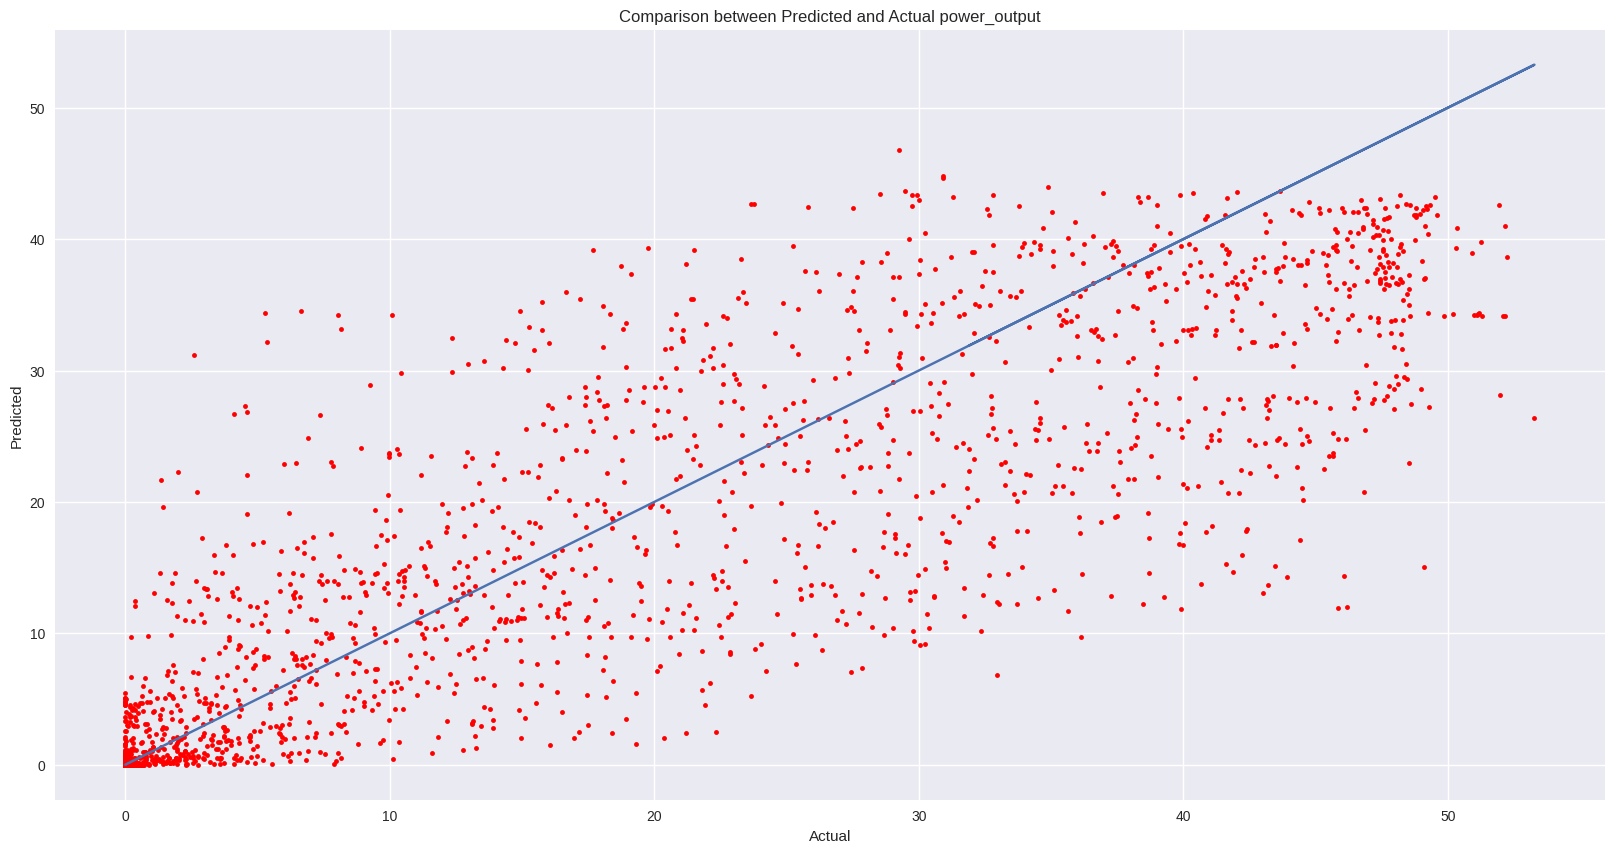

In [448]:
ran_0 = compare_1(RandomForestRegressor(random_state=0),solar0,solar0_test)
ran_0

In [449]:
#solar11 = solar1.loc[pd.Timestamp('2019-10-01 00:00:00'):pd.Timestamp('2020-11-01 09:45:00')]
#solar11

In [450]:
random_f_solar1 = reg_model(RandomForestRegressor(random_state=0),solar1,solar1_test)
random_f_solar1

,R^2,RMSE,MAE
train,0.989271,0.392334,0.220841
test,0.834354,1.744650,1.180584


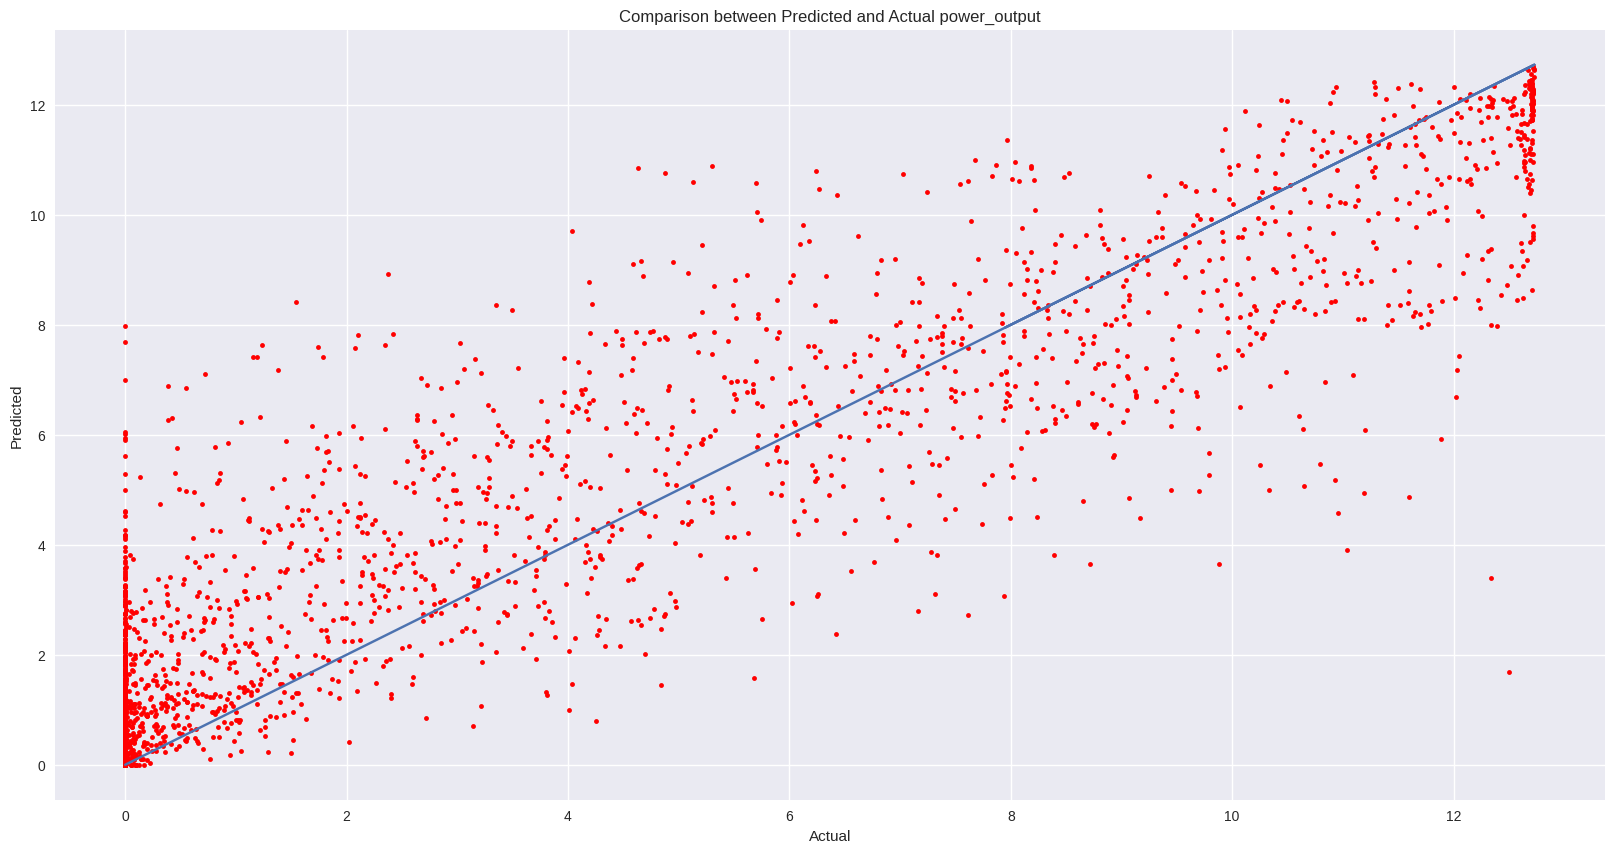

In [451]:
ran_1 = compare_1(RandomForestRegressor(random_state=0),solar1,solar1_test)
ran_1

In [452]:
random_f_solar2 = reg_model(RandomForestRegressor(random_state=0),solar2,solar2_test)
random_f_solar2

,R^2,RMSE,MAE
train,0.990893,0.323366,0.178345
test,0.859313,1.604292,0.992485


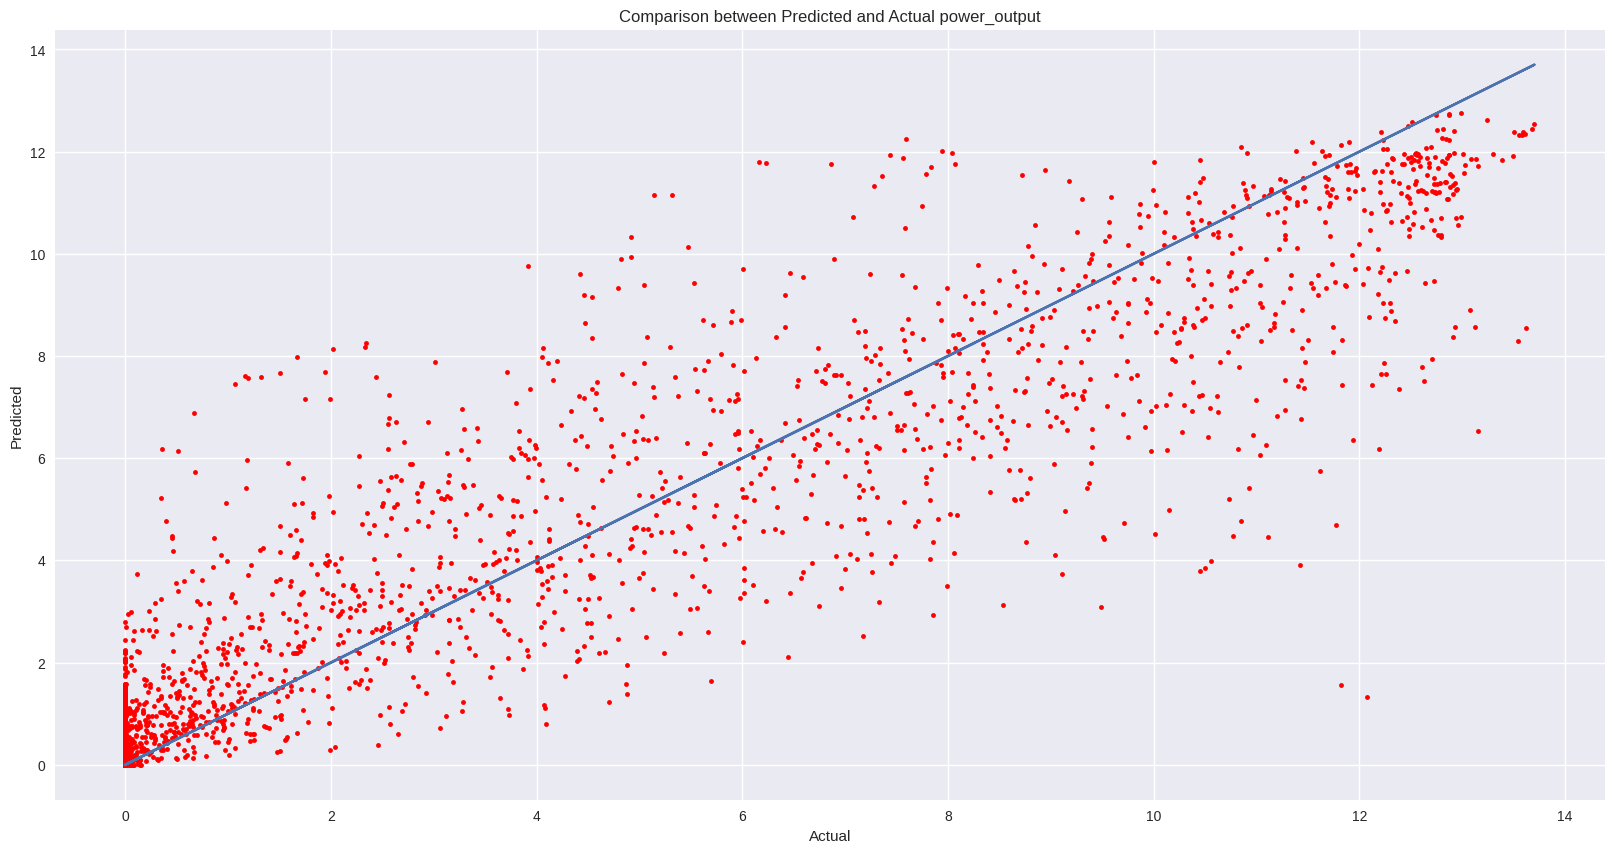

In [453]:
ran_2 = compare_1(RandomForestRegressor(random_state=0),solar2,solar2_test)
ran_2

In [454]:
random_f_solar3 = reg_model(RandomForestRegressor(random_state=0),solar3,solar3_test)
random_f_solar3

,R^2,RMSE,MAE
train,0.988719,0.261621,0.131213
test,0.728473,1.995481,1.295386


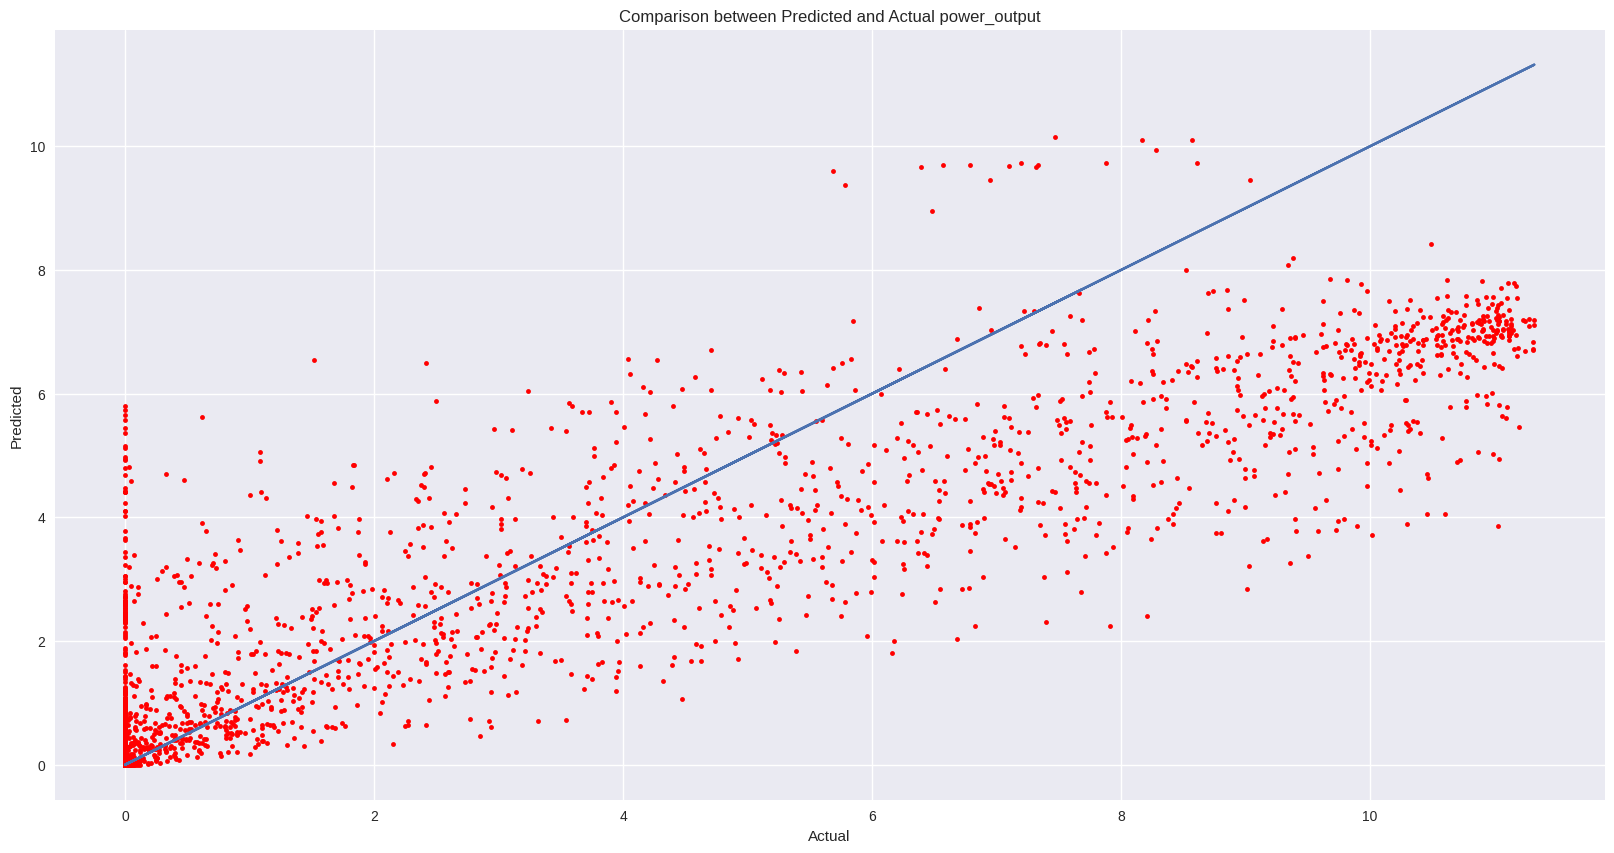

In [455]:
ran_3 = compare_1(RandomForestRegressor(random_state=0),solar3,solar3_test)
ran_3

In [456]:
random_f_solar4 = reg_model(RandomForestRegressor(random_state=0),solar4,solar4_test)
random_f_solar4

,R^2,RMSE,MAE
train,0.991311,0.190242,0.102831
test,0.856731,0.960340,0.601579


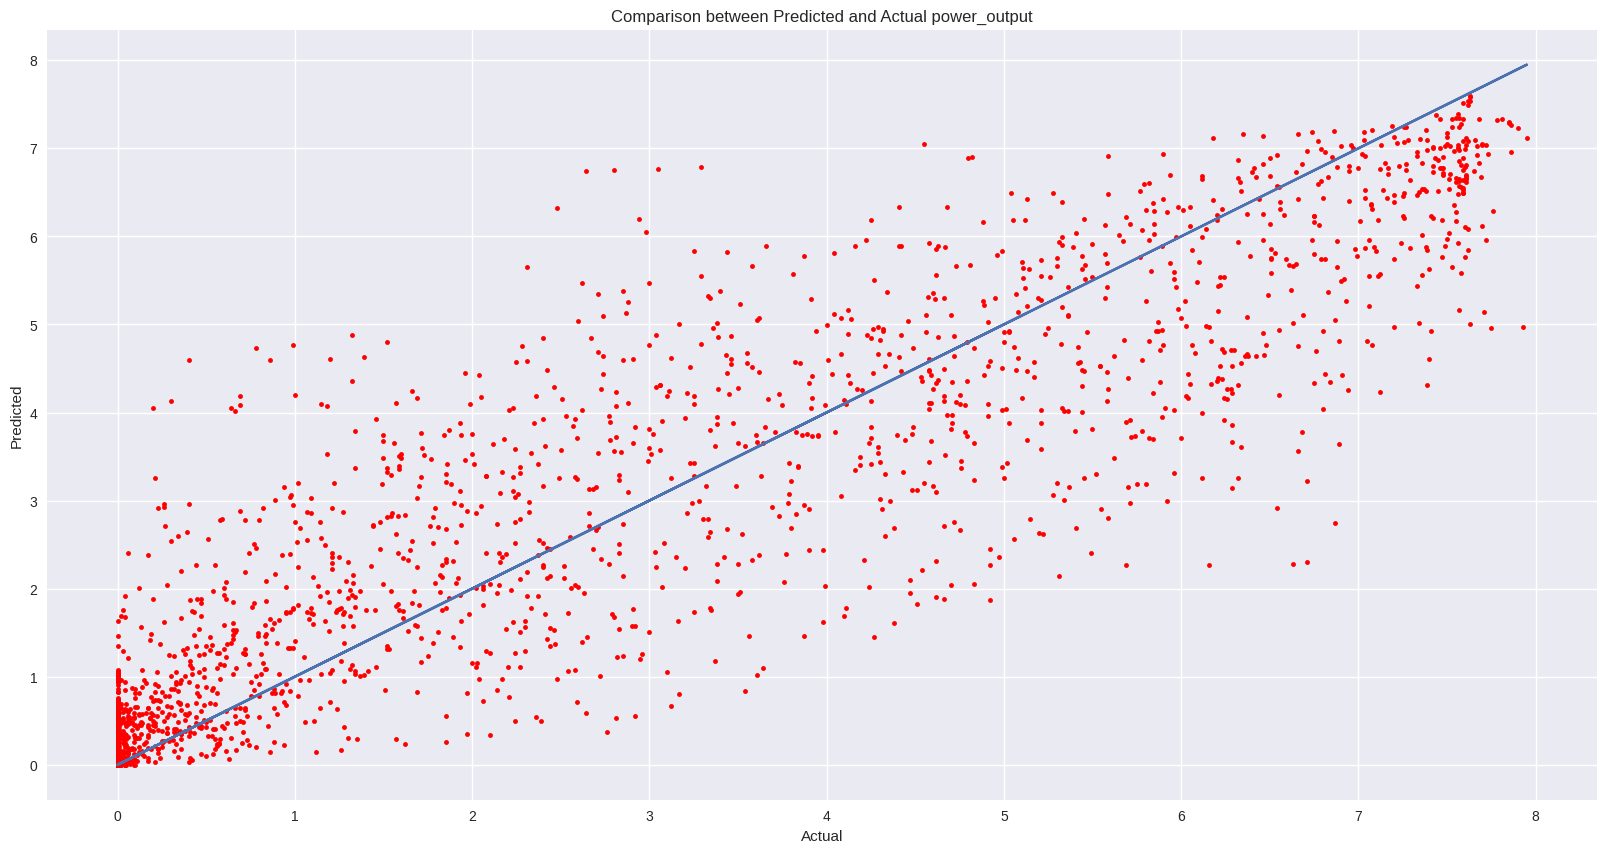

In [457]:
ran_4 = compare_1(RandomForestRegressor(random_state=0),solar4,solar4_test)
ran_4

In [458]:
random_f_solar5 = reg_model(RandomForestRegressor(random_state=0),solar5,solar5_test)
random_f_solar5

,R^2,RMSE,MAE
train,0.990468,1.040273,0.513375
test,0.855194,4.915345,2.733096


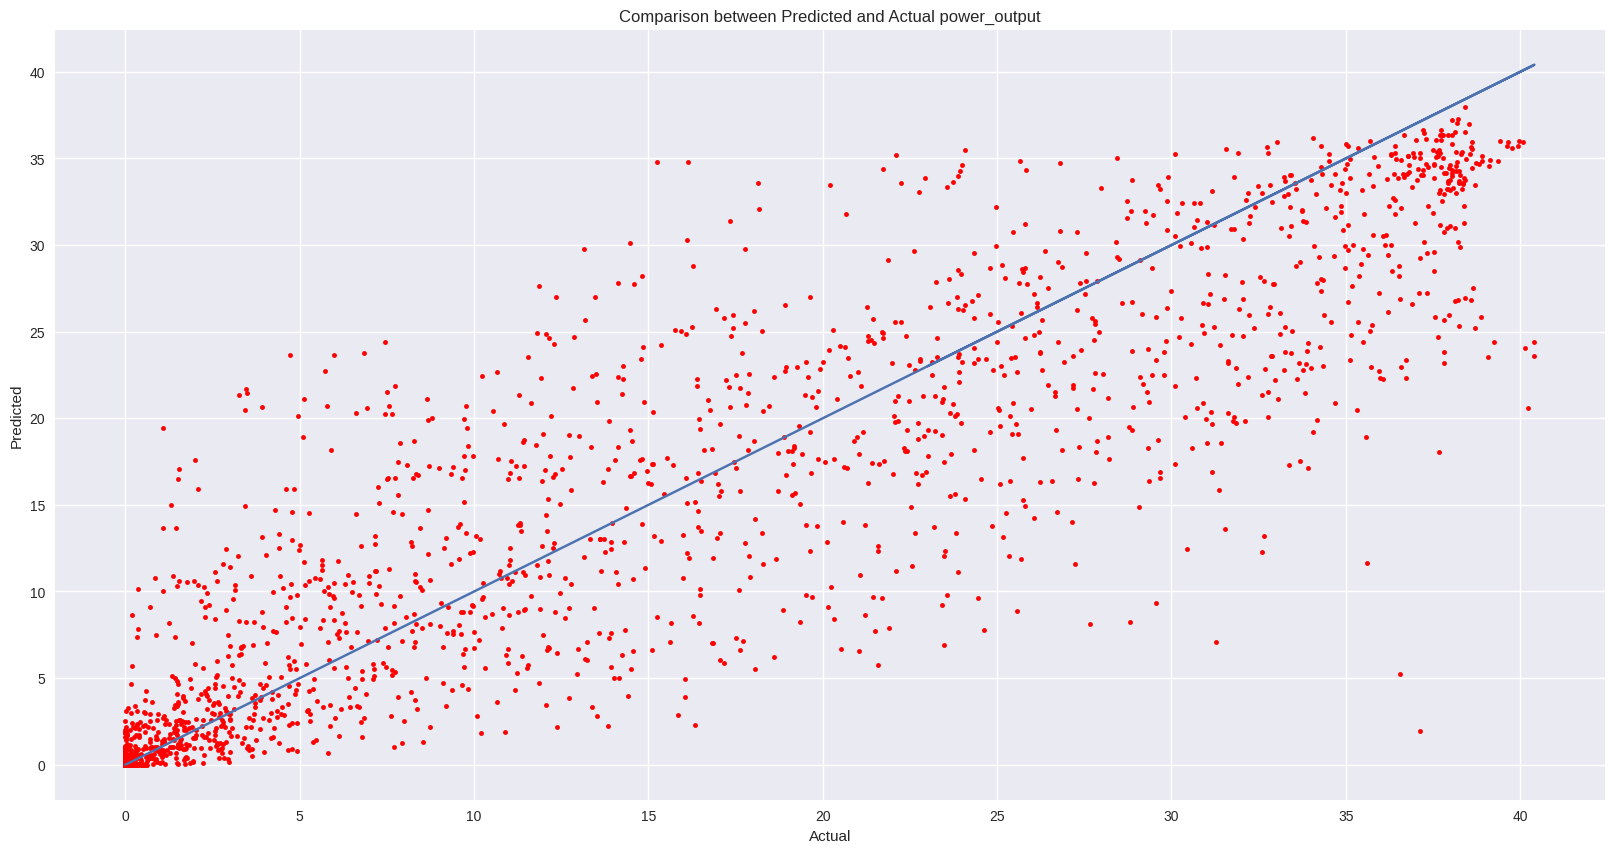

In [459]:
ran_5 = compare_1(RandomForestRegressor(),solar5,solar5_test)
ran_5

## Feature selection

In [460]:
def feature_select(solar_train, solar_test):
    '''Selecting features'''
    import numpy as np
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import r2_score
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error # for comparing the predicted and test values
    import seaborn as sns
    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import chi2, f_regression

    X_train = solar_train.drop(["power_output"], axis = 1)
    X_test = solar_test.drop(["power_output"], axis = 1)
    Y_train = solar_train['power_output']
    Y_test = solar_test['power_output']

    features_new = SelectKBest(f_regression, k = "all")
    features_new.fit(X_train, Y_train)
    #pipe.get_feature_names_out()
    df_scores = pd.DataFrame(features_new.scores_)
    df_columns = pd.DataFrame(X_train.columns)
    # concatenate dataframes
    anova_scores = pd.concat([df_columns, df_scores],axis=1)
    anova_scores.columns = ['Feature_Name','Score']  # name output columns

    anova_scores.set_index('Feature_Name', inplace=True)
    anova_scores.sort_values(by='Score').plot(kind='barh', figsize=(8, 7)) # plot these as a bar plot

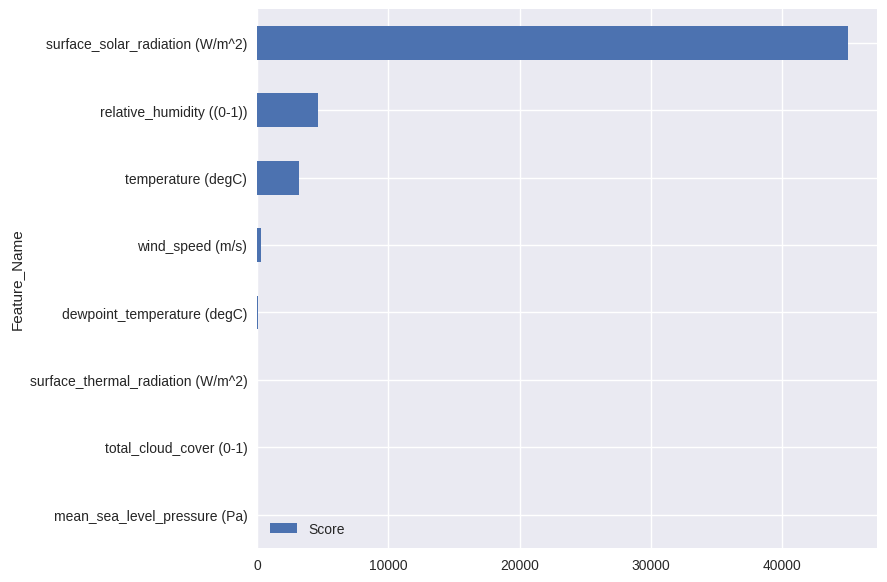

In [461]:
fea_solar_0 = feature_select(solar0,solar0_test)
fea_solar_0

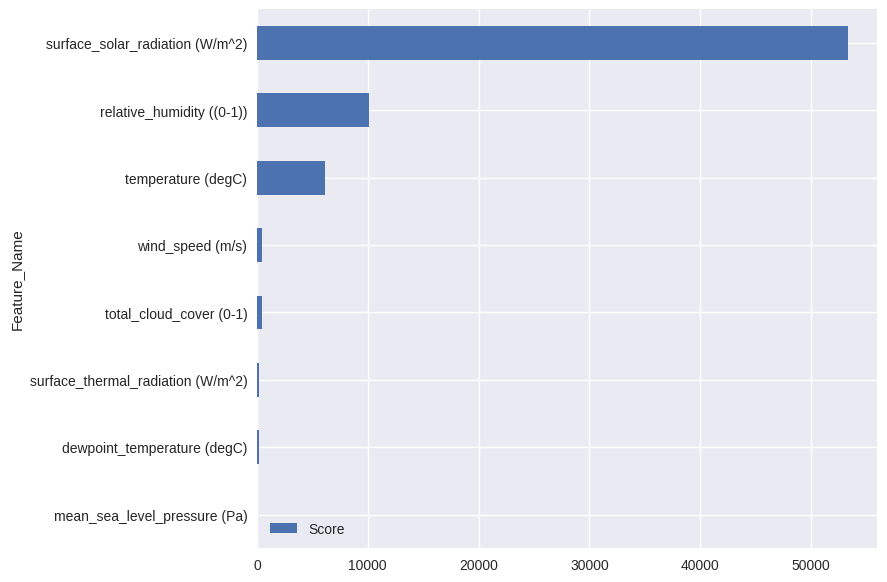

In [462]:
fea_solar_1 = feature_select(solar1,solar1_test)
fea_solar_1

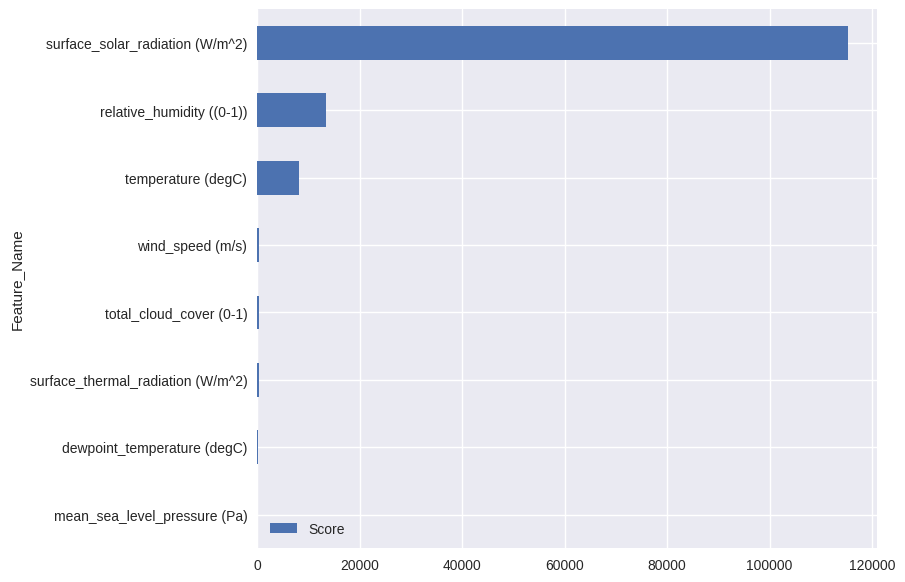

In [463]:
fea_solar_2 = feature_select(solar2,solar2_test)
fea_solar_2

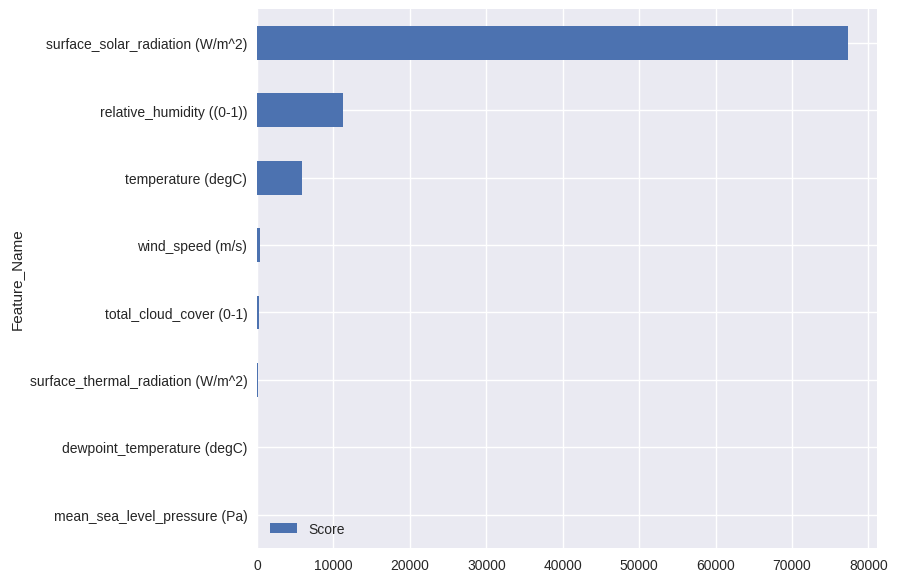

In [464]:
fea_solar_3 = feature_select(solar3,solar3_test)
fea_solar_3

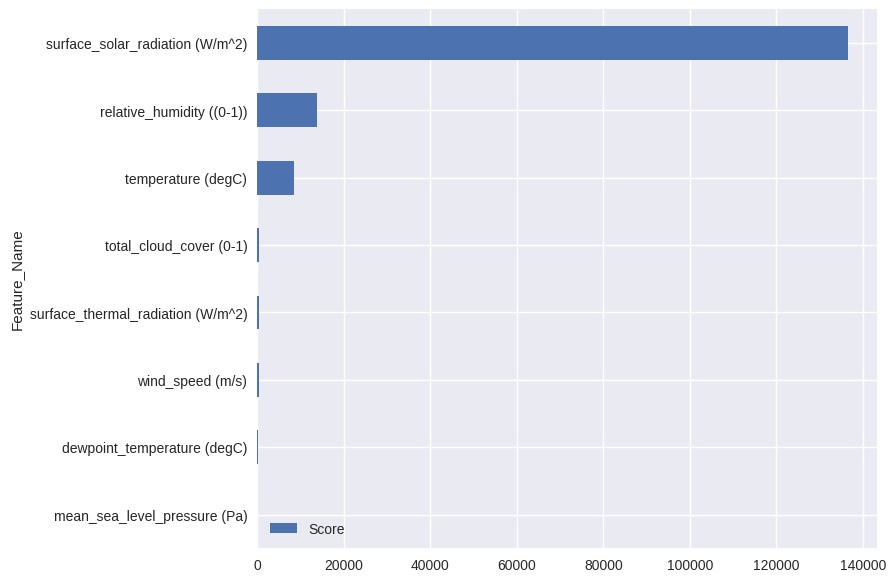

In [465]:
fea_solar_4 = feature_select(solar4,solar4_test)
fea_solar_4

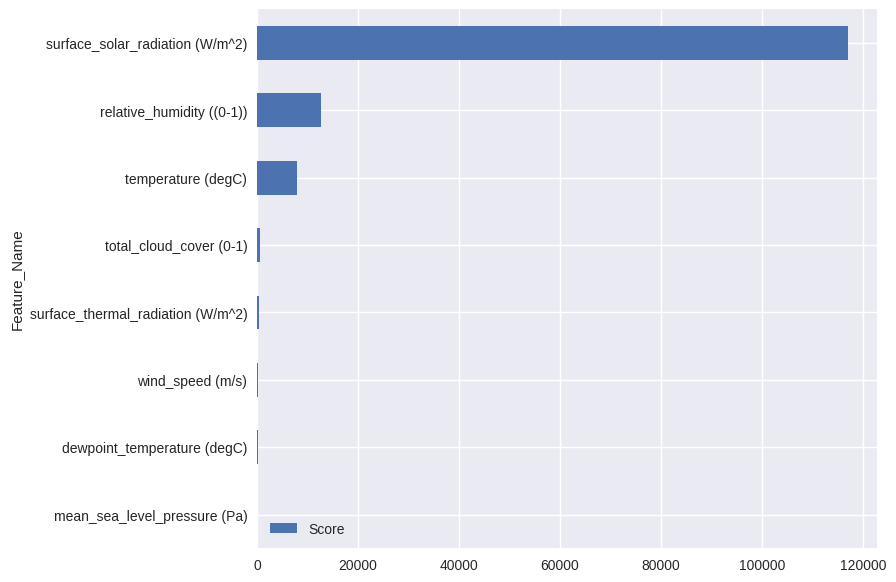

In [466]:
fea_solar_5 = feature_select(solar5,solar5_test)
fea_solar_5

In [467]:
def new_reg_model(model, solar_train, solar_test):
    '''Convenience function to fit an sklearn regression model and calculate the r2 score'''
    import numpy as np
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import r2_score
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error # for comparing the predicted and test values
    import seaborn as sns

    X_train = solar_train[['surface_solar_radiation (W/m^2)','relative_humidity ((0-1))','temperature (degC)']]
    X_test = solar_test[['surface_solar_radiation (W/m^2)','relative_humidity ((0-1))','temperature (degC)']]
    Y_train = solar_train['power_output']
    Y_test = solar_test['Power output']

    pipe = make_pipeline(StandardScaler(), model)
    pipe.fit(X_train, Y_train)  # apply scaling on training data

    training_predictions = pipe.predict(X_train)  # Get model predictions for both.
    testing_predictions = pipe.predict(X_test)    # training and testing data.

# Create a table of the various scores.
    results = pd.DataFrame({
        "R^2": {
            "train": r2_score(Y_train, training_predictions),
            "test": r2_score(Y_test, testing_predictions)
        },
        "RMSE": {
            "train": mean_squared_error(Y_train, training_predictions, squared=False),
            "test": mean_squared_error(Y_test, testing_predictions, squared=False),
        },
        "MAE": {
            "train": mean_absolute_error(Y_train, training_predictions),
            "test": mean_absolute_error(Y_test, testing_predictions),
        },
    })
    return results

In [468]:
def new_reg_predicted(model, solar_train, solar_test):
    '''Output predictions'''
    import numpy as np
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import r2_score
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error # for comparing the predicted and test values
    import seaborn as sns

    X_train = solar_train[['surface_solar_radiation (W/m^2)','relative_humidity ((0-1))','temperature (degC)']]
    X_test = solar_test[['surface_solar_radiation (W/m^2)','relative_humidity ((0-1))','temperature (degC)']]
    Y_train = solar_train['power_output']
    Y_test = solar_test['power_output']

    pipe = make_pipeline(StandardScaler(), model)
    pipe.fit(X_train, Y_train)  # apply scaling on training data

    training_predictions = pipe.predict(X_train)  # Get model predictions for both.
    testing_predictions = pipe.predict(X_test)    # training and testing data.

    return testing_predictions

In [469]:
def compare(model,solar,solar_test):
    lin_solar_pred_old = reg_predicted(model,solar,solar_test)
    d = {'Predicted': lin_solar_pred_old, 'Actual': solar_test['power_output']}
    df = pd.DataFrame(data=d)
    df = df.reset_index(0)
    df = df.replace(df['Predicted'].loc[df['Predicted']<0].values[:],0)


    lin_solar_pred = new_reg_predicted(model,solar,solar_test)
    d5 = {'Predicted': lin_solar_pred, 'Actual': solar_test['power_output']}
    df5 = pd.DataFrame(data=d5)
    df5 = df5.reset_index(0)
    df5 = df5.replace(df5['Predicted'].loc[df5['Predicted']<0].values[:],0)


    #df = df.loc[df['timestamp']>"2020-11-15 00:00:00"]
    #df5 = df5.loc[df5['timestamp']>"2020-11-15 00:00:00"]



    plt.rcParams["figure.figsize"] = [20, 10]
    #plt.plot(df['timestamp'],df['Predicted'], color='green',label="Predicted_all_features")
    #plt.plot(df5['timestamp'],df5['Predicted'], color='red',label="Predicted_selected_features")
    #plt.plot(df5['timestamp'],df5['Actual'], color='blue',label="Actual")

    plt.plot(df5['Actual'],df['Predicted'],'r.',label="Predicted_all_features")
    plt.plot(df5['Actual'],df5['Predicted'],'r.', color='green',label="Predicted_selected_features")
    plt.plot(df5['Actual'],df5['Actual'], color='blue',label="Identity line")

    plt.legend()
    plt.title('Comparison between Predicted power_output of 2 RandomForest models')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    #plt.tick_params(axis='x', labelrotation = 45)
    plt.show()

<ipython-input-469-c34aa1b91821>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  plt.plot(df5['Actual'],df5['Predicted'],'r.', color='green',label="Predicted_selected_features")


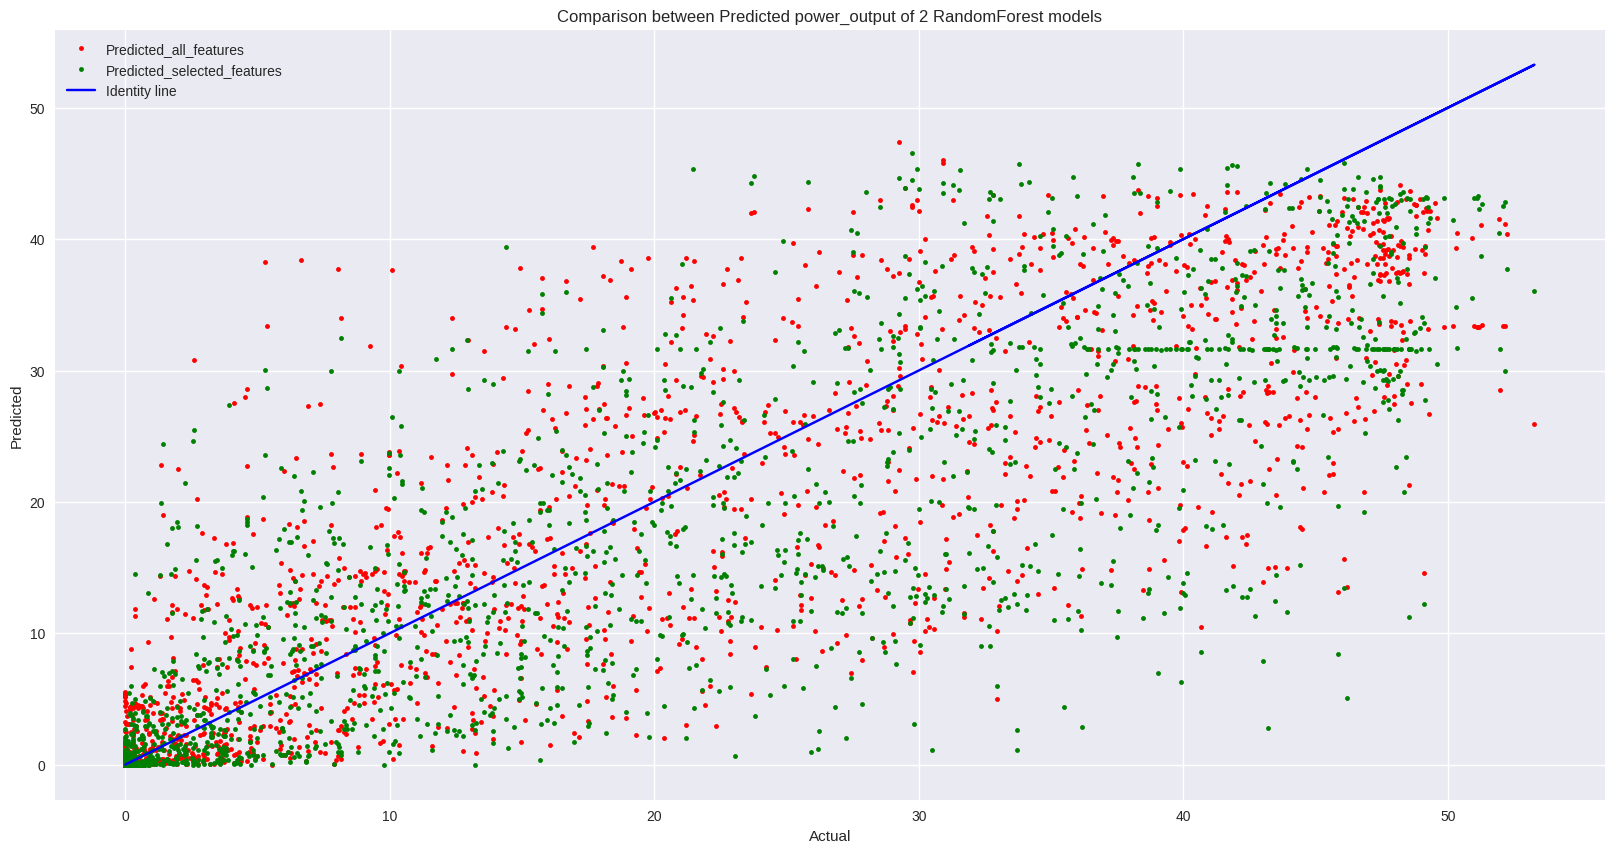

In [470]:
new_ran_0 = compare(RandomForestRegressor(),solar0,solar0_test)
new_ran_0

<ipython-input-469-c34aa1b91821>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  plt.plot(df5['Actual'],df5['Predicted'],'r.', color='green',label="Predicted_selected_features")


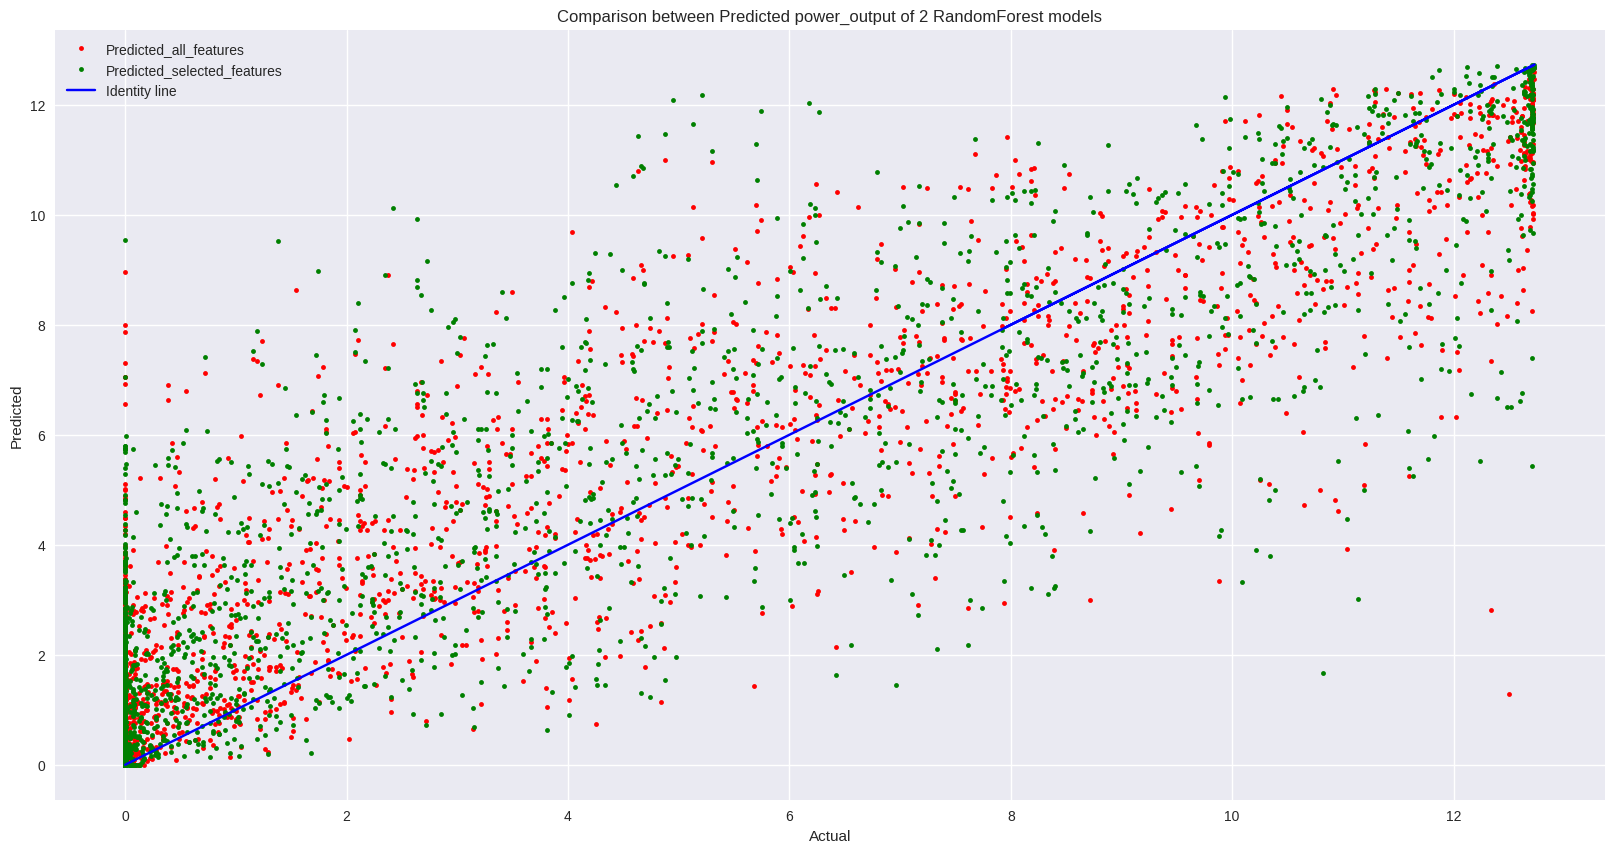

In [471]:
new_ran_1 = compare(RandomForestRegressor(),solar1,solar1_test)
new_ran_1

<ipython-input-469-c34aa1b91821>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  plt.plot(df5['Actual'],df5['Predicted'],'r.', color='green',label="Predicted_selected_features")


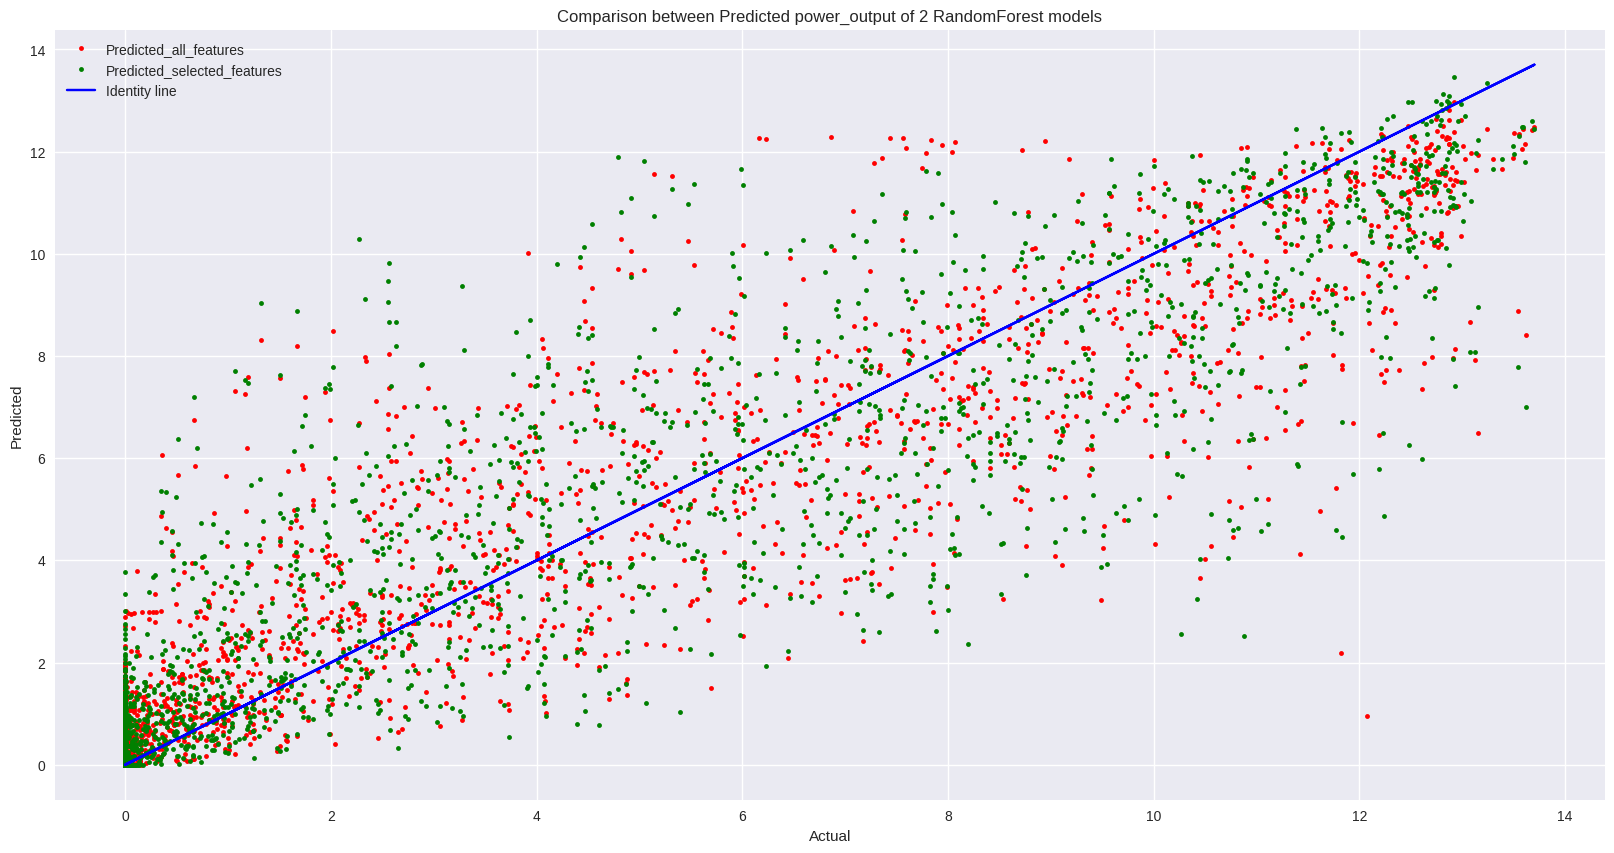

In [472]:
new_ran_2 = compare(RandomForestRegressor(),solar2,solar2_test)
new_ran_2

<ipython-input-469-c34aa1b91821>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  plt.plot(df5['Actual'],df5['Predicted'],'r.', color='green',label="Predicted_selected_features")


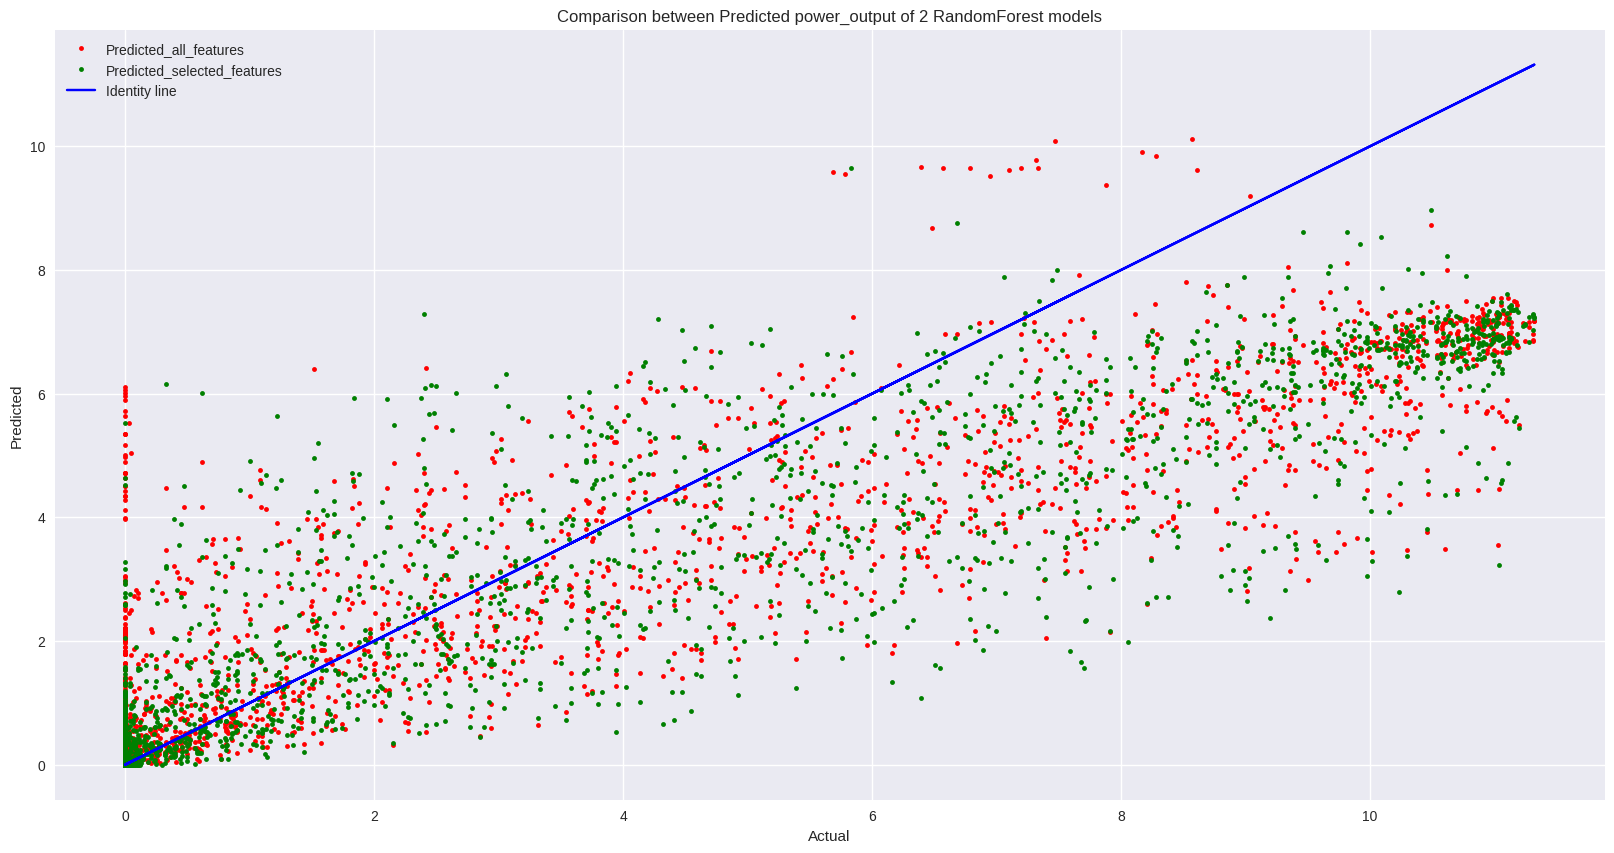

In [473]:
new_ran_3 = compare(RandomForestRegressor(),solar3,solar3_test)
new_ran_3

<ipython-input-469-c34aa1b91821>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  plt.plot(df5['Actual'],df5['Predicted'],'r.', color='green',label="Predicted_selected_features")


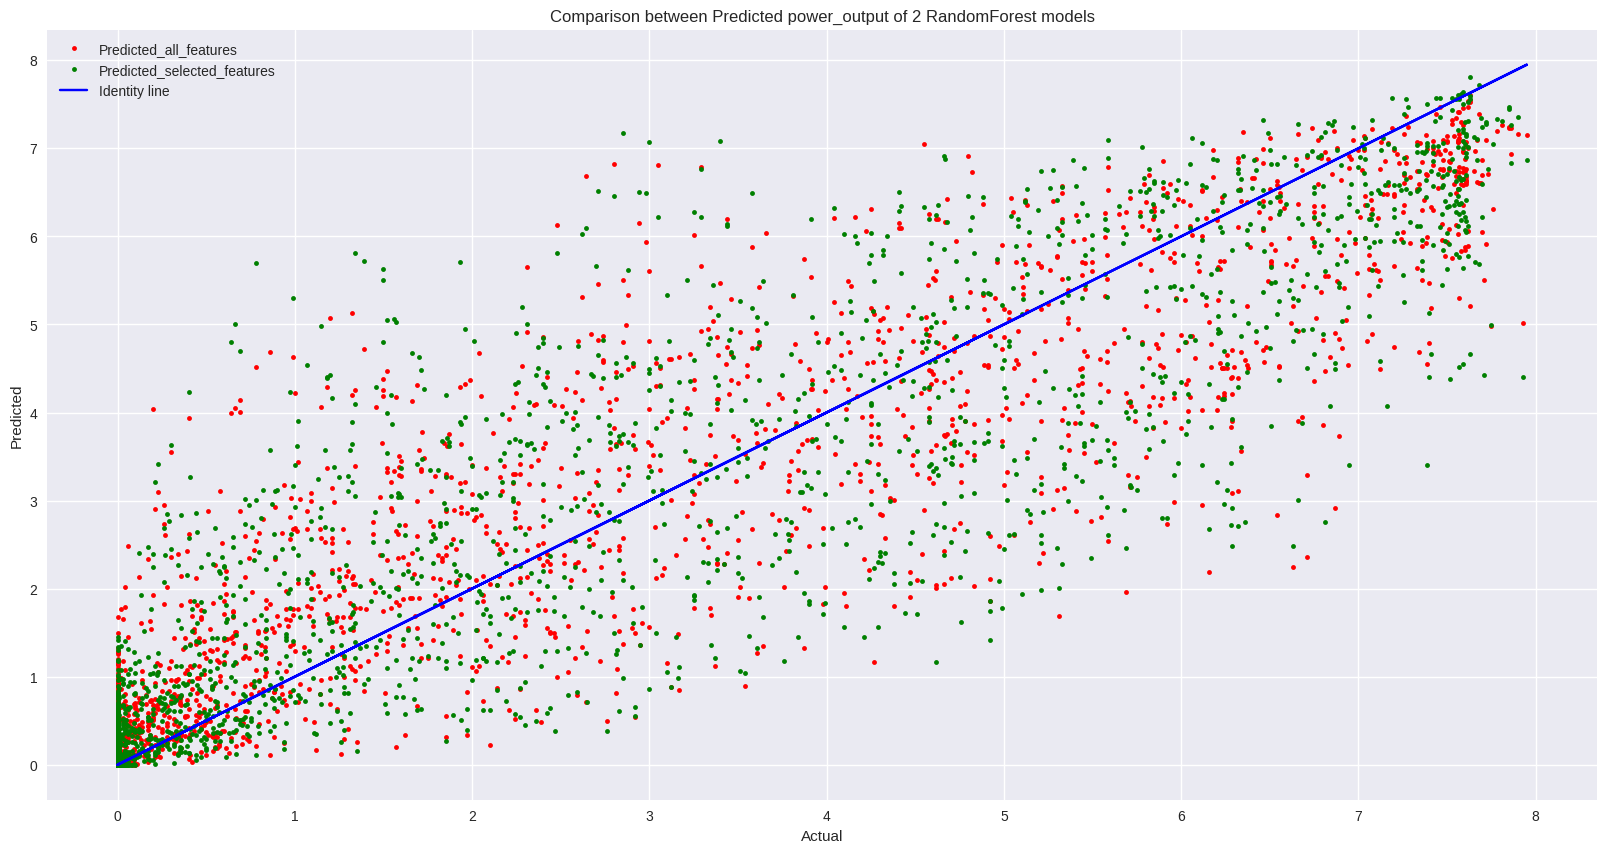

In [474]:
new_ran_4 = compare(RandomForestRegressor(),solar4,solar4_test)
new_ran_4

<ipython-input-469-c34aa1b91821>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  plt.plot(df5['Actual'],df5['Predicted'],'r.', color='green',label="Predicted_selected_features")


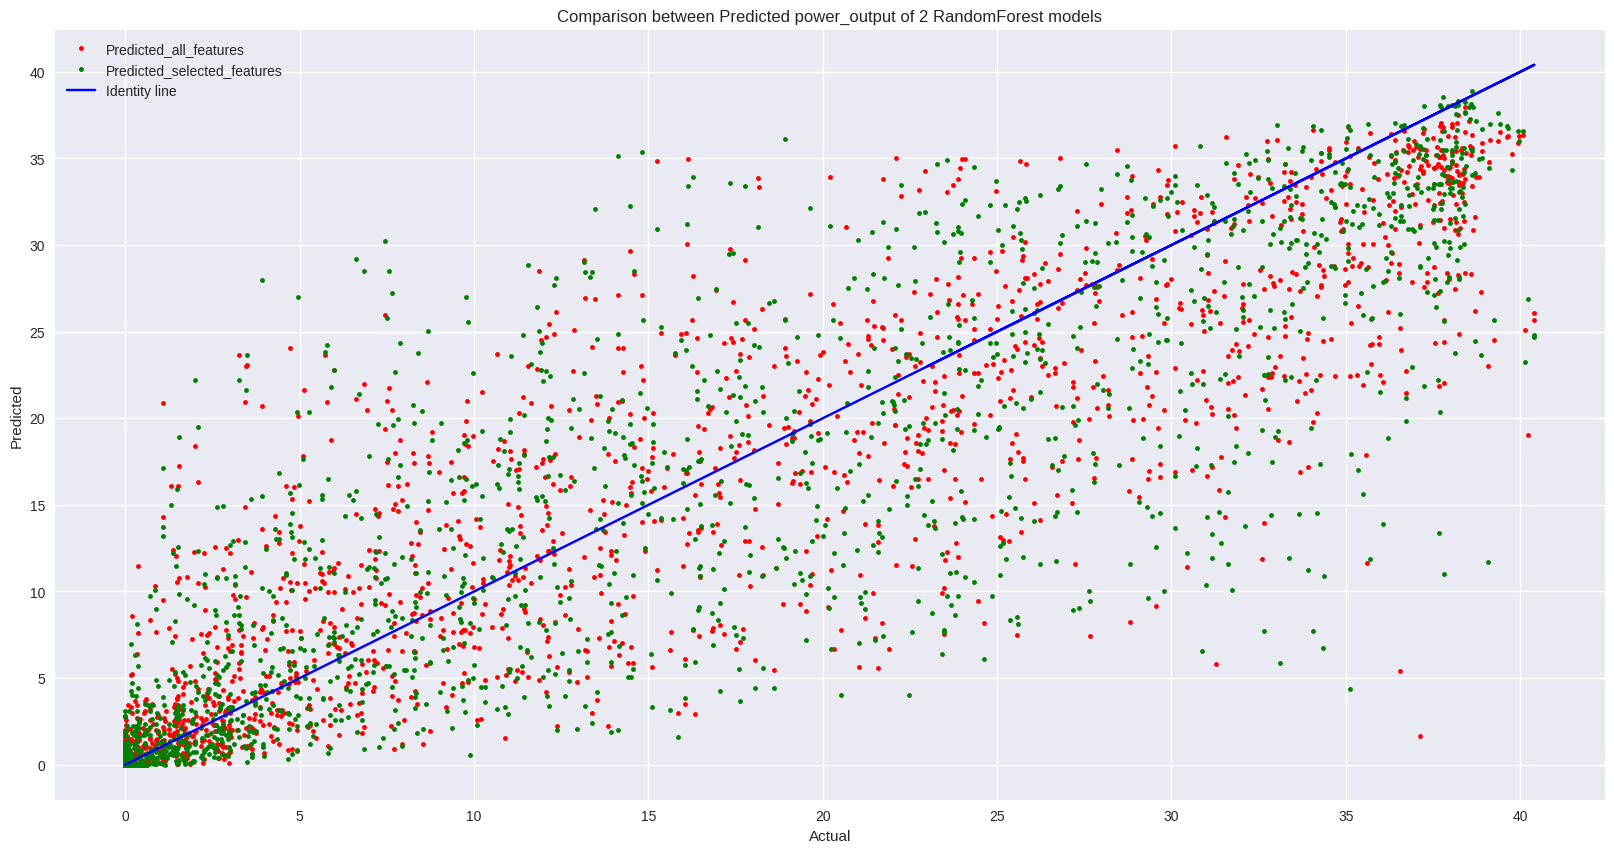

In [475]:
new_ran_5 = compare(RandomForestRegressor(),solar5,solar5_test)
new_ran_5